# Prédiction de l'Accès à la Fibre Optique (FTTH) au Togo

## I. Introduction du Projet

### Contexte
Ce projet vise à prédire l'accès à la fibre optique (FTTH - Fiber To The Home) au Togo en utilisant des techniques de Machine Learning. Le dataset combine :
- **Données socio-démographiques** du RGPH / INSEED (caractéristiques des ménages)
- **Données clients FTTH** des opérateurs Togocom et GVA
- **Données d'observation de la Terre** provenant de l'API MOSAIKS (4000 features satellite)

### Objectif
Prédire pour chaque point géographique :
- **Target = 1** : Accès Internet FTTH
- **Target = 0** : Pas d'accès Internet FTTH

### Caractéristiques du Dataset
- **Observations** : ~30,558 ménages
- **Variables** : 4,002 colonnes (40 socio-démographiques + 4000 MOSAIKS + coordonnées + cible)
- **Variable cible** : `Accès internet`

### Contraintes Techniques
- Split Train/Test : **80/20**
- Random state : **45** (obligatoire pour reproductibilité)
- Métriques principales : **AUC-ROC** et **F1-Score**

### Structure du Notebook
1. Imports et Configuration
2. Chargement et Exploration des Données
3. Préprocessing et Nettoyage
4. Feature Engineering et Sélection de Variables
5. Modélisation (Logistic Regression, Random Forest, XGBoost, LightGBM, SVM, MLP)
6. Évaluation et Comparaison des Modèles
7. Interprétabilité (SHAP, Feature Importance)
8. Export des Prédictions Finales

## II. Imports et Configuration

### Bibliothèques utilisées :
- **pandas, numpy** : Manipulation et analyse des données
- **matplotlib, seaborn** : Visualisation des données et résultats
- **scikit-learn** : Préprocessing, modélisation, métriques et pipelines
- **xgboost, lightgbm** : Modèles de gradient boosting performants
- **shap** : Interprétabilité des modèles (valeurs SHAP)
- **warnings** : Gestion des avertissements

In [1]:
! pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
# =============================================================================
# IMPORTS - BIBLIOTHÈQUES NÉCESSAIRES
# =============================================================================
# Ce bloc importe toutes les bibliothèques nécessaires au projet.
# Chaque import est commenté pour expliquer son utilité.

# --- Manipulation des données ---
import pandas as pd                    # Manipulation de DataFrames
import numpy as np                     # Calcul numérique et tableaux

# --- Visualisation ---
import matplotlib.pyplot as plt        # Graphiques de base
import seaborn as sns                  # Visualisations statistiques avancées

# --- Préprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# --- Réduction de dimension et sélection de features ---
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE, RFECV

# --- Modèles de classification ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# --- Gradient Boosting avancé ---
import xgboost as xgb
import lightgbm as lgb

# --- Métriques d'évaluation ---
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

# --- Optimisation des hyperparamètres ---
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# --- Interprétabilité ---
import shap

# --- Utilitaires ---
import warnings
from collections import Counter
import os
from datetime import datetime

# =============================================================================
# CONFIGURATION GLOBALE
# =============================================================================

# Ignorer les avertissements pour un affichage plus propre
warnings.filterwarnings('ignore')

# Configuration de l'affichage pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Configuration matplotlib/seaborn
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# =============================================================================
# CONSTANTES DU PROJET (NE PAS MODIFIER)
# =============================================================================

RANDOM_STATE = 45          # Seed pour reproductibilité (OBLIGATOIRE)
TEST_SIZE = 0.20           # 20% pour le test, 80% pour l'entraînement
N_JOBS = -1                # Utiliser tous les cœurs CPU disponibles

print("[SUCCESS] Imports et configuration terminés avec succès")
print(f"Random State: {RANDOM_STATE}")
print(f"Test Size: {TEST_SIZE*100:.0f}%")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

[SUCCESS] Imports et configuration terminés avec succès
Random State: 45
Test Size: 20%
Timestamp: 2025-12-18 21:53:12


c:\Users\fredb\anaconda3\envs\FTTH_Togo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## III. Chargement et Exploration des Données

### Objectifs de cette section :
1. Charger le dataset principal
2. Examiner la structure et les dimensions
3. Identifier les types de variables
4. Analyser les valeurs manquantes
5. Explorer la distribution de la variable cible
6. Visualiser les corrélations principales

In [3]:
# =============================================================================
# CHARGEMENT DES DONNÉES (OPTIMISÉ POUR FICHIER VOLUMINEUX - 2.2 Go)
# =============================================================================
import os
import gc

# Chemins vers les fichiers de données (relatifs au dossier notebooks/)
DATA_PATH = "../Data/Data.csv"
PARQUET_PATH = "../Data/Data.parquet"
OUTPUT_DIR = "../Output"

# Création du dossier Output s'il n'existe pas
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Vérification de l'existence d'une version Parquet  (beaucoup plus rapide et moins de mémoire)
if os.path.exists(PARQUET_PATH):
    print(" Chargement depuis le fichier Parquet (rapide)...")
    df = pd.read_parquet(PARQUET_PATH)
    print(f"Données chargées avec succès!")
else:
    print(" Premier chargement depuis CSV...")
    print(" Le fichier fait 2.2 Go - utilisation du chargement par chunks")
    print(" Une version Parquet sera créée pour accélérer les prochains chargements.\n")
    
    # Lecture des colonnes d'abord 
    print("Lecture des noms de colonnes...")
    cols = pd.read_csv(DATA_PATH, nrows=0).columns.tolist()
    print(f"   {len(cols)} colonnes détectées")
    
    # Définition des types optimisés pour réduire la mémoire
    # CORRECTION: ID est une chaîne (ex: 'ID_88M0FMHZAM'), pas un entier
    dtype_dict = {}
    for col in cols:
        # Colonnes MOSAIKS (commencent par un chiffre ou un point)
        if len(col) > 0 and (col[0].isdigit() or col.startswith('.')):
            dtype_dict[col] = 'float32'
        elif col == 'ID':
            dtype_dict[col] = 'str'  # ID est une chaîne de caractères !
        elif col == 'Accès internet':
            dtype_dict[col] = 'float32'  # Peut contenir des NaN, donc float
        elif col in ['BoxLabel', 'Connexion']:
            dtype_dict[col] = 'str'  # Catégories textuelles
        elif col in ['longitude', 'latitude']:
            dtype_dict[col] = 'float32'
    
    # Chargement par chunks pour éviter l'erreur de mémoire
    print("\n Chargement par chunks (5000 lignes à la fois)...")
    chunks = []
    chunk_size = 5000
    total_rows = 0
    
    try:
        for i, chunk in enumerate(pd.read_csv(
            DATA_PATH,
            dtype=dtype_dict,
            chunksize=chunk_size,
            low_memory=True,
            # on_bad_lines='skip'  # Ignorer les lignes problématiques
        )):
            chunks.append(chunk)
            total_rows += len(chunk)
            if (i + 1) % 2 == 0:
                print(f"   Chunk {i+1} chargé ({total_rows:,} lignes)")
            gc.collect()  # Libérer la mémoire entre les chunks
        
        print(f"\n Concaténation des {len(chunks)} chunks...")
        df = pd.concat(chunks, ignore_index=True)
        del chunks
        gc.collect()
        
        # Sauvegarder en Parquet pour les prochaines fois
        print("\nSauvegarde en format Parquet...")
        df.to_parquet(PARQUET_PATH, compression='snappy', index=False)
        print(f"Fichier Parquet créé: {PARQUET_PATH}")
        gc.collect()
        
    except Exception as e:
        print(f"\n Erreur lors du chargement: {e}")
        print("\nTentative de chargement sans types forcés...")
        
        # Plan B: charger sans forcer les types
        chunks = []
        for i, chunk in enumerate(pd.read_csv(
            DATA_PATH,
            chunksize=chunk_size,
            low_memory=False,
            on_bad_lines='skip'
        )):
            chunks.append(chunk)
            if (i + 1) % 2 == 0:
                print(f"   Chunk {i+1} chargé")
            gc.collect()
        
        df = pd.concat(chunks, ignore_index=True)
        del chunks
        gc.collect()
        
        # Sauvegarder en Parquet
        df.to_parquet(PARQUET_PATH, compression='snappy', index=False)
        print(f"Fichier Parquet créé: {PARQUET_PATH}")

print(f"\n{'='*60}")
print(f"DONNÉES CHARGÉES AVEC SUCCÈS!")
print(f"{'='*60}")
print(f"\n Dimensions du dataset:")
print(f"   - Nombre d'observations (ménages): {df.shape[0]:,}")
print(f"   - Nombre de variables: {df.shape[1]:,}")
print(f"   - Mémoire utilisée: {df.memory_usage(deep=True).sum() / 1e9:.2f} Go")

 Chargement depuis le fichier Parquet (rapide)...
Données chargées avec succès!

DONNÉES CHARGÉES AVEC SUCCÈS!

 Dimensions du dataset:
   - Nombre d'observations (ménages): 30,558
   - Nombre de variables: 4,043
   - Mémoire utilisée: 1.06 Go


In [4]:
# =============================================================================
# APERÇU INITIAL DES DONNÉES
# =============================================================================
# Examen des premières et dernières lignes pour comprendre la structure

print("Aperçu des premières lignes:")
display(df.head())

print("\n Aperçu des dernières lignes:")
display(df.tail())

Aperçu des premières lignes:


,ID,TypeLogmt_1,TypeLogmt_2,TypeLogmt_3,H08_Impute,H09_Impute,TAILLE_MENAGE,H17A,H17B,H17C,H17D,H17E,H17F,H17G,H17H,H17I,H17J,H17Y,H18A,H18B,H18C,H18D,H18E,H18F,H18G,H18H,H18I,H18J,H18Y,H20A,H20B,H20C,H20D,H20E,H20Y,H21A,H21B,H21C,H21D,H21Y,Connexion,BoxLabel,,.1,.2,.3,.4,.5,.6,.7,...,.3951,.3952,.3953,.3954,.3955,.3956,.3957,.3958,.3959,.3960,.3961,.3962,.3963,.3964,.3965,.3966,.3967,.3968,.3969,.3970,.3971,.3972,.3973,.3974,.3975,.3976,.3977,.3978,.3979,.3980,.3981,.3982,.3983,.3984,.3985,.3986,.3987,.3988,.3989,.3990,.3991,.3992,.3993,.3994,.3995,.3996,.3997,.3998,.3999,Accès internet
0,ID_88M0FMHZAM,Logement semi-moderne,Plusieurs logement,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Gaz,1.0000,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Oui,GVA,Box0,0.1109,0.3645,0.0822,0.0510,0.1802,0.4407,0.0911,0.3502,...,1.7311,0.0335,0.2160,0.0000,0.7134,0.0031,0.0398,0.8309,0.9800,0.0144,1.0433,0.0371,0.0126,0.0000,0.0830,0.1124,1.1667,0.3180,1.4512,0.1323,0.0000,0.2652,0.4593,0.0494,0.3786,0.0131,0.0231,0.0006,0.0788,0.6730,0.1950,0.3278,0.2916,0.7440,0.1702,0.5038,0.0668,0.0000,0.0604,0.1838,0.0252,0.2354,0.2514,0.1259,0.8350,1.0551,0.5031,0.7619,0.0184,0.0000
1,ID_8BRUVGMYT4,Logement semi-moderne,Plusieurs logement,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Gaz,4.0000,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Oui,Non,Oui,Non,Oui,Non,Non,Non,Non,Non,Oui,GVA,Box0,0.0705,0.1745,0.0772,0.0095,0.0654,0.1811,0.0894,0.5134,...,0.5441,0.3049,0.1034,0.0000,0.5694,0.0138,0.1754,0.7152,0.9748,0.0875,0.0478,0.1112,0.1174,0.0072,0.3079,0.4206,0.3416,0.6093,1.1344,0.2306,0.0032,0.3944,0.3350,0.0902,0.7372,0.1545,0.2308,0.0843,0.1324,0.2653,0.6512,0.3779,0.5725,0.3741,0.1935,0.2170,0.3188,0.0043,0.1913,0.2163,0.4179,0.3955,0.2435,0.4082,0.2789,1.1345,0.1654,0.1176,0.2141,1.0000
2,ID_BLWKMPQSDG,Logement moderne,Plusieurs logement,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Charbon de bois,1.0000,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Oui,GVA,Box0,0.1844,0.5294,0.0381,0.4089,0.3447,0.3687,0.0984,0.1167,...,2.1356,0.0550,0.2855,0.0000,1.0766,0.0088,0.0615,1.1982,1.3193,0.0261,0.9402,0.0536,0.0346,0.0000,0.1473,0.1779,1.1530,0.6125,1.9521,0.2131,0.0000,0.3306,0.6128,0.0868,0.7327,0.0298,0.0251,0.0040,0.1289,0.6690,0.2795,0.4948,0.4717,0.8187,0.2273,0.5151,0.1282,0.0000,0.1093,0.2809,0.0598,0.3682,0.2555,0.1951,0.9762,1.5702,0.6698,0.7365,0.0379,0.0000
3,ID_5FF71INFJ2,Logement moderne,Plusieurs logement,Logement ? un niveau (plain-pied),Electricit? (CEET) compteur dans la concession,Gaz,4.0000,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Oui,Non,Oui,Oui,Oui,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Togocom,Box0,0.1731,0.4889,0.0448,0.2995,0.3135,0.4260,0.0835,0.1210,...,1.8590,0.0877,0.3481,0.0000,1.1710,0.0136,0.0475,1.3658,1.5019,0.0412,0.7551,0.0791,0.0539,0.0000,0.1870,0.2349,1.3136,0.7586,2.0882,0.2291,0.0000,0.3611,0.6933,0.1110,0.8719,0.0406,0.0422,0.0064,0.1867,0.7404,0.3824,0.6258,0.5711,0.8406,0.2631,0.5243,0.1792,0.0000,0.1340,0.3358,0.1016,0.4741,0.3426,0.2283,1.0541,1.8051,0.6039,0.7466,0.0516,1.0000
4,ID_BL1YKKNQ4Y,Logement moderne,Plusieurs logement,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Charbon de bois,1.0000,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Oui,None,Box0,0.1663,0.5325,0.0344,0.4010,0.3019,0.4050,0.0727,0.1016,...,1.8940,0.0734,0.3162,0.0000,1.1312,0.0167,0.0543,1.2960,1.4500,0.0288,0.9592,0.0762,0.0510,0.0000,0.1777,0.2018,1.2970,0.6851,2.1079,0.1857,0.0000,0.4013,0.6610,0.1021,0.8056,0.0423,0.0338,0.0083,0.1571,0.8094,0.3423,0.5590,0.5183,0.8160,0.2


 Aperçu des dernières lignes:


,ID,TypeLogmt_1,TypeLogmt_2,TypeLogmt_3,H08_Impute,H09_Impute,TAILLE_MENAGE,H17A,H17B,H17C,H17D,H17E,H17F,H17G,H17H,H17I,H17J,H17Y,H18A,H18B,H18C,H18D,H18E,H18F,H18G,H18H,H18I,H18J,H18Y,H20A,H20B,H20C,H20D,H20E,H20Y,H21A,H21B,H21C,H21D,H21Y,Connexion,BoxLabel,,.1,.2,.3,.4,.5,.6,.7,...,.3951,.3952,.3953,.3954,.3955,.3956,.3957,.3958,.3959,.3960,.3961,.3962,.3963,.3964,.3965,.3966,.3967,.3968,.3969,.3970,.3971,.3972,.3973,.3974,.3975,.3976,.3977,.3978,.3979,.3980,.3981,.3982,.3983,.3984,.3985,.3986,.3987,.3988,.3989,.3990,.3991,.3992,.3993,.3994,.3995,.3996,.3997,.3998,.3999,Accès internet
30553,ID_SLCZUGKFO5,Logement moderne,Logement unique,Logement ? un niveau (plain-pied),Electricit? (CEET) compteur dans la concession,Charbon de bois,5.0000,Oui,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Oui,Non,Non,Non,Non,Non,Oui,Togocom,Box0,0.1109,0.3645,0.0822,0.0510,0.1802,0.4407,0.0911,0.3502,...,1.7311,0.0335,0.2160,0.0000,0.7134,0.0031,0.0398,0.8309,0.9800,0.0144,1.0433,0.0371,0.0126,0.0000,0.0830,0.1124,1.1667,0.3180,1.4512,0.1323,0.0000,0.2652,0.4593,0.0494,0.3786,0.0131,0.0231,0.0006,0.0788,0.6730,0.1950,0.3278,0.2916,0.7440,0.1702,0.5038,0.0668,0.0000,0.0604,0.1838,0.0252,0.2354,0.2514,0.1259,0.8350,1.0551,0.5031,0.7619,0.0184,1.0000
30554,ID_D2JVKCG1T8,Logement semi-moderne,Plusieurs logement,Logement ? un niveau (plain-pied),Electricit? (CEET) compteur dans la concession,Charbon de bois,1.0000,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Togocom,Box0,0.0390,0.0561,0.0451,0.0002,0.0389,0.0979,0.0721,0.3287,...,1.8623,0.0757,0.3267,0.0000,1.1668,0.0200,0.0418,1.2274,1.4421,0.0258,1.0183,0.0483,0.0484,0.0000,0.1371,0.1935,1.1925,0.6101,1.9259,0.1735,0.0000,0.3477,0.5600,0.0949,0.8607,0.0282,0.0350,0.0090,0.1394,0.7246,0.3214,0.5337,0.5365,0.7526,0.2228,0.5003,0.1391,0.0001,0.1105,0.3264,0.0839,0.3779,0.2210,0.2060,1.0474,1.7515,0.5930,0.7174,0.0374,1.0000
30555,ID_KDYM8R7ZDH,Logement moderne,Plusieurs logement,Logement ? plusieurs niveaux (? ?tage),Electricit? (CEET) compteur dans la concession,Gaz,5.0000,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Oui,Non,Non,Oui,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Oui,Non,Oui,Non,Non,Non,Non,Non,Oui,Togocom,Box0,0.1663,0.5325,0.0344,0.4010,0.3019,0.4050,0.0727,0.1016,...,1.8940,0.0734,0.3162,0.0000,1.1312,0.0167,0.0543,1.2960,1.4500,0.0288,0.9592,0.0762,0.0510,0.0000,0.1777,0.2018,1.2970,0.6851,2.1079,0.1857,0.0000,0.4013,0.6610,0.1021,0.8056,0.0423,0.0338,0.0083,0.1571,0.8094,0.3423,0.5590,0.5183,0.8160,0.2231,0.5532,0.1520,0.0000,0.1190,0.3184,0.0945,0.4107,0.2485,0.2225,1.0122,1.7250,0.5827,0.7703,0.0376,0.0000
30556,ID_KWQPPHS6CE,Logement moderne,Logement unique,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Gaz,1.0000,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Oui,Non,Oui,Oui,Oui,Non,Non,Oui,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,GVA,Box0,0.0515,0.0697,0.0614,0.0001,0.0492,0.1314,0.0799,0.4422,...,2.5594,0.3392,0.8444,0.0000,2.2838,0.1640,0.3023,2.4840,2.3965,0.2237,1.0852,0.4202,0.2818,0.0014,0.6169,0.7159,2.0883,1.5151,3.2100,0.5789,0.0020,0.7862,1.3859,0.3694,1.8485,0.1536,0.2417,0.0826,0.5272,1.4673,0.7788,1.3652,1.3024,1.4059,0.7002,1.0315,0.5345,0.0011,0.4391,0.8747,0.4371,1.0831,0.7292,0.6081,1.6224,3.1897,1.0260,1.2902,0.1838,0.0000
30557,ID_QAHVASRC5Z,Logement moderne,Logement unique,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Gaz,2.0000,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Oui,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Oui,GVA,Box0,0.1597,0.4510,0.0282,0.3609,0.2679,0.3779,0.0947,0.0996,...,1.8827,0.0323,0.2412,0.0000,0.8271,0.0053,0.0633,0.9027,1.1165,0.0140,0.9511,0.0407,0.0216,0.0000,0.0939,0.1404,1.1981,0.4191,1.5041,0.1710,0.0000,0.2554,0.5688,0.0608,0.4905,0.0179,0.0153,0.0018,0.1050,0.6797,0.2777,0.3963

In [5]:
# =============================================================================
# IDENTIFICATION DES COLONNES ET LEURS TYPES
# =============================================================================
# Séparation des colonnes en catégories pour faciliter le traitement

# Liste de toutes les colonnes
all_columns = df.columns.tolist()

# Identification des colonnes socio-démographiques (variables du RGPH)
socio_demo_cols = [col for col in all_columns if not col.startswith(' .') 
                   and col not in ['ID', 'Accès internet', 'Connexion', 'BoxLabel']]

# Identification des colonnes MOSAIKS (commencent par " .")
mosaiks_cols = [col for col in all_columns if col.startswith(' .')]

# Colonnes spéciales
id_col = 'ID'
target_col = 'Accès internet'
connexion_col = 'Connexion' if 'Connexion' in all_columns else None
boxlabel_col = 'BoxLabel' if 'BoxLabel' in all_columns else None

print(" Catégorisation des variables:")
print(f"   - ID: {id_col}")
print(f"   - Variable cible: {target_col}")
print(f"   - Connexion: {connexion_col}")
print(f"   - BoxLabel: {boxlabel_col}")
print(f"\n   - Variables socio-démographiques: {len(socio_demo_cols)} colonnes")
print(f"   - Variables MOSAIKS (satellite): {len(mosaiks_cols)} colonnes")

# Affichage des variables socio-démographiques
print(f"\n Variables socio-démographiques:")
for i, col in enumerate(socio_demo_cols, 1):
    print(f"   {i:2d}. {col}")

 Catégorisation des variables:
   - ID: ID
   - Variable cible: Accès internet
   - Connexion: Connexion
   - BoxLabel: BoxLabel

   - Variables socio-démographiques: 40 colonnes
   - Variables MOSAIKS (satellite): 3999 colonnes

 Variables socio-démographiques:
    1. TypeLogmt_1
    2. TypeLogmt_2
    3. TypeLogmt_3
    4. H08_Impute
    5. H09_Impute
    6. TAILLE_MENAGE
    7. H17A
    8. H17B
    9. H17C
   10. H17D
   11. H17E
   12. H17F
   13. H17G
   14. H17H
   15. H17I
   16. H17J
   17. H17Y
   18. H18A
   19. H18B
   20. H18C
   21. H18D
   22. H18E
   23. H18F
   24. H18G
   25. H18H
   26. H18I
   27. H18J
   28. H18Y
   29. H20A
   30. H20B
   31. H20C
   32. H20D
   33. H20E
   34. H20Y
   35. H21A
   36. H21B
   37. H21C
   38. H21D
   39. H21Y
   40.  


In [6]:
# =============================================================================
# ANALYSE DES TYPES DE DONNÉES
# =============================================================================
# Vérification des types de données pour chaque colonne

print("Types de données par catégorie:")
print("\n--- Types généraux ---")
print(df.dtypes.value_counts())

print("\n--- Informations détaillées ---")
df.info(verbose=True, show_counts=True)

Types de données par catégorie:

--- Types généraux ---
float64    4001
object       41
float32       1
Name: count, dtype: int64

--- Informations détaillées ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30558 entries, 0 to 30557
Data columns (total 4043 columns):
 #     Column          Non-Null Count  Dtype  
---    ------          --------------  -----  
 0     ID              30558 non-null  object 
 1     TypeLogmt_1     30558 non-null  object 
 2     TypeLogmt_2     30558 non-null  object 
 3     TypeLogmt_3     30558 non-null  object 
 4     H08_Impute      30558 non-null  object 
 5     H09_Impute      30558 non-null  object 
 6     TAILLE_MENAGE   30558 non-null  float64
 7     H17A            30558 non-null  object 
 8     H17B            30558 non-null  object 
 9     H17C            30558 non-null  object 
 10    H17D            30558 non-null  object 
 11    H17E            30558 non-null  object 
 12    H17F            30558 non-null  object 
 13    H17G          

Analyse des valeurs manquantes:
   - Colonnes avec valeurs manquantes: 1
   - Total de valeurs manquantes: 10,508

 Top 20 colonnes avec le plus de valeurs manquantes:


,Valeurs Manquantes,Pourcentage (%)
Connexion,10508,34.3871


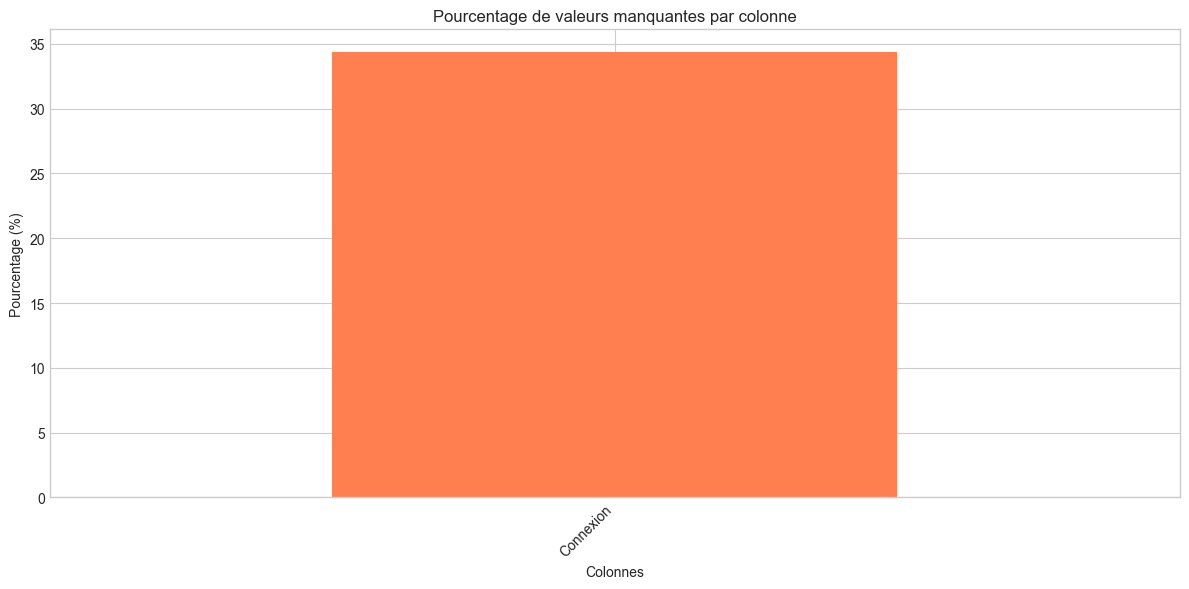

In [7]:
# =============================================================================
# ANALYSE DES VALEURS MANQUANTES
# =============================================================================
# Identification et quantification des valeurs manquantes

# Calcul des valeurs manquantes
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

# Création d'un DataFrame récapitulatif
missing_df = pd.DataFrame({
    'Valeurs Manquantes': missing_values,
    'Pourcentage (%)': missing_percent
}).sort_values('Valeurs Manquantes', ascending=False)

# Filtrer uniquement les colonnes avec des valeurs manquantes
missing_df_filtered = missing_df[missing_df['Valeurs Manquantes'] > 0]

print("Analyse des valeurs manquantes:")
print(f"   - Colonnes avec valeurs manquantes: {len(missing_df_filtered)}")
print(f"   - Total de valeurs manquantes: {missing_values.sum():,}")

if len(missing_df_filtered) > 0:
    print("\n Top 20 colonnes avec le plus de valeurs manquantes:")
    display(missing_df_filtered.head(20))
else:
    print("\n Aucune valeur manquante détectée!")

# Visualisation des valeurs manquantes (si présentes)
if len(missing_df_filtered) > 0 and len(missing_df_filtered) <= 50:
    fig, ax = plt.subplots(figsize=(12, 6))
    missing_df_filtered['Pourcentage (%)'].plot(kind='bar', ax=ax, color='coral')
    plt.title('Pourcentage de valeurs manquantes par colonne')
    plt.xlabel('Colonnes')
    plt.ylabel('Pourcentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

 Analyse de la Variable Cible: 'Accès internet'

 Distribution:
   - Classe 0 (Pas d'accès): 15,650 (51.21%)
   - Classe 1 (Accès FTTH): 14,908 (48.79%)

 Ratio de déséquilibre: 1.05:1
    Équilibre acceptable


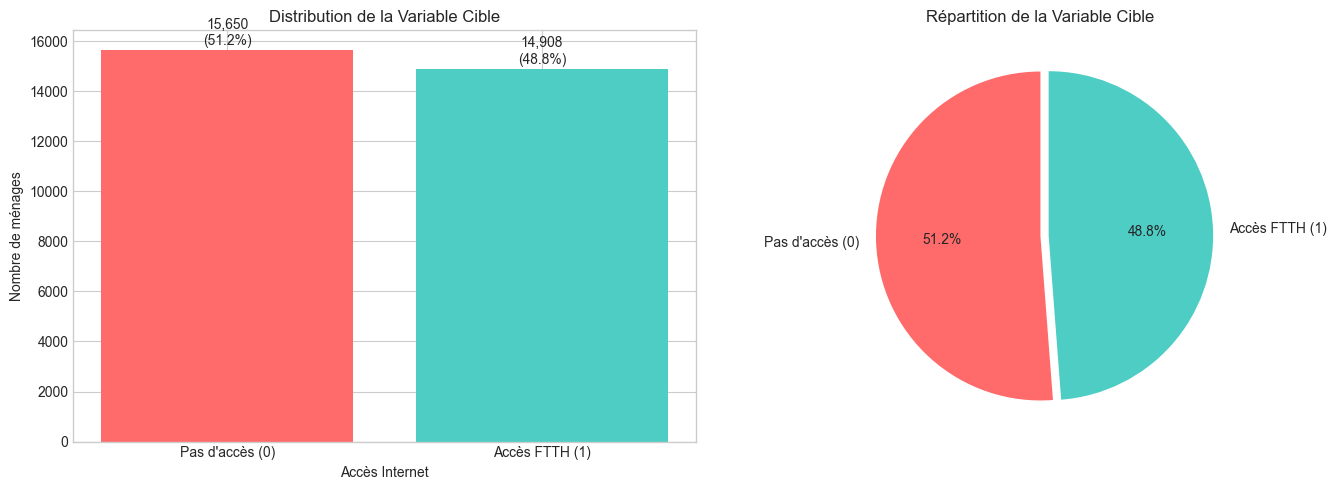


 Graphique sauvegardé: '../Output/target_distribution.png'


In [8]:
# =============================================================================
# ANALYSE DE LA VARIABLE CIBLE
# =============================================================================
# Exploration de la distribution de la variable cible 'Accès internet'
# Cette variable binaire indique la présence (1) ou l'absence (0) de FTTH

print(" Analyse de la Variable Cible: 'Accès internet'")
print("=" * 50)

# Distribution de la variable cible
target_dist = df[target_col].value_counts()
target_pct = df[target_col].value_counts(normalize=True) * 100

print(f"\n Distribution:")
print(f"   - Classe 0 (Pas d'accès): {target_dist[0]:,} ({target_pct[0]:.2f}%)")
print(f"   - Classe 1 (Accès FTTH): {target_dist[1]:,} ({target_pct[1]:.2f}%)")

# Calcul du ratio de déséquilibre
imbalance_ratio = target_dist[0] / target_dist[1]
print(f"\n Ratio de déséquilibre: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3 or imbalance_ratio < 0.33:
    print("    Déséquilibre significatif détecté - techniques de rééquilibrage recommandées")
else:
    print("    Équilibre acceptable")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Bar plot
colors = ['#ff6b6b', '#4ecdc4']
axes[0].bar(target_dist.index.astype(str), target_dist.values, color=colors)
axes[0].set_xlabel('Accès Internet')
axes[0].set_ylabel('Nombre de ménages')
axes[0].set_title('Distribution de la Variable Cible')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Pas d\'accès (0)', 'Accès FTTH (1)'])

# Ajouter les valeurs sur les barres
for i, (val, pct) in enumerate(zip(target_dist.values, target_pct.values)):
    axes[0].text(i, val + 200, f'{val:,}\n({pct:.1f}%)', ha='center', fontsize=10)

# Graphique 2: Pie chart
axes[1].pie(target_dist.values, labels=['Pas d\'accès (0)', 'Accès FTTH (1)'], 
            colors=colors, autopct='%1.1f%%', startangle=90, explode=[0, 0.05])
axes[1].set_title('Répartition de la Variable Cible')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Graphique sauvegardé: '{OUTPUT_DIR}/target_distribution.png'")

In [9]:
# =============================================================================
# STATISTIQUES DESCRIPTIVES DES VARIABLES NUMÉRIQUES
# =============================================================================
# Analyse des statistiques de base pour comprendre les distributions

print(" Statistiques descriptives des variables socio-démographiques:")
print("=" * 60)

# Statistiques pour les colonnes socio-démographiques numériques
socio_numeric_cols = df[socio_demo_cols].select_dtypes(include=[np.number]).columns.tolist()
display(df[socio_numeric_cols].describe().T)

print(f"\n Statistiques descriptives des features MOSAIKS (échantillon de 10):")
print("=" * 60)

# Afficher les stats pour un échantillon de colonnes MOSAIKS
sample_mosaiks = mosaiks_cols[:10]
display(df[sample_mosaiks].describe().T)

 Statistiques descriptives des variables socio-démographiques:


,count,mean,std,min,25%,50%,75%,max
TAILLE_MENAGE,30558.0000,4.4759,2.9349,1.0000,2.0000,4.0000,6.0000,36.0000
,30558.0000,0.2063,0.1323,0.0037,0.1157,0.1795,0.2661,0.7143



 Statistiques descriptives des features MOSAIKS (échantillon de 10):


,count,mean,std,min,25%,50%,75%,max
.1,30558.0000,0.5288,0.2973,0.0135,0.3645,0.5324,0.7012,1.4350
.2,30558.0000,0.0798,0.0686,0.0049,0.0388,0.0487,0.0917,0.4103
.3,30558.0000,0.3147,0.2120,0.0000,0.1613,0.3337,0.4522,0.9375
.4,30558.0000,0.3346,0.2093,0.0035,0.2097,0.3216,0.4548,1.0101
.5,30558.0000,0.4792,0.2878,0.0242,0.3225,0.4167,0.5806,1.6646
.6,30558.0000,0.1472,0.1007,0.0306,0.0815,0.1013,0.1714,0.6379
.7,30558.0000,0.2508,0.1716,0.0204,0.1108,0.1684,0.3523,0.9786
.8,30558.0000,0.2456,0.1808,0.0000,0.0985,0.2423,0.3573,0.8113
.9,30558.0000,0.4562,0.2684,0.0154,0.2885,0.4363,0.5630,1.3680
.10,30558.0000,0.4022,0.2448,0.0008,0.2360,0.4200,0.5371,1.1219


In [10]:
# =============================================================================
# NETTOYAGE: COLONNES SANS NOM ET DOUBLONS
# =============================================================================
# Gestion des colonnes avec des noms vides ou problématiques et vérification des doublons

print("Nettoyage des données...")

# 1. IDENTIFIER ET GÉRER LES COLONNES SANS NOM
print("\ Analyse des colonnes sans nom ou avec noms problématiques:")

# Trouver les colonnes avec des noms vides ou espaces
problematic_cols = []
for i, col in enumerate(df.columns):
    if col == '' or col.strip() == '' or col.isspace():
        problematic_cols.append((i, col, repr(col)))
        print(f"    Index {i}: nom='{repr(col)}' - Type: {df[col].dtype}")
        print(f"      Premières valeurs: {df[col].head(3).tolist()}")

if problematic_cols:
    print(f"\n    {len(problematic_cols)} colonne(s) avec nom vide/problématique trouvée(s)")
    
    # Renommer les colonnes sans nom
    # La colonne sans nom (index 42) semble être la première feature MOSAIKS (numérotée .0)
    new_columns = list(df.columns)
    for idx, old_name, _ in problematic_cols:
        # Vérifier si c'est une feature MOSAIKS 
        col_min = df.iloc[:, idx].min()
        col_max = df.iloc[:, idx].max()
        
        # Renommer en .0 si c'est probablement la première feature MOSAIKS
        if 0 <= col_min <= 1 and 0 <= col_max <= 2:
            new_name = '.0'
            print(f"    Colonne index {idx} renommée: '{repr(old_name)}' → '{new_name}'")
        else:
            new_name = f'unnamed_{idx}'
            print(f"    Colonne index {idx} renommée: '{repr(old_name)}' → '{new_name}'")
        
        new_columns[idx] = new_name
    
    df.columns = new_columns
    print(f"\n    Colonnes renommées avec succès")
else:
    print("    Aucune colonne sans nom détectée")

# Mettre à jour la liste des colonnes MOSAIKS
mosaiks_cols = [col for col in df.columns if col.startswith('.') or (col[0].isdigit() if col else False)]
print(f"\n    Mise à jour: {len(mosaiks_cols)} colonnes MOSAIKS identifiées")

# 2. VÉRIFICATION DES DOUBLONS
print("\n Vérification des doublons:")

# Doublons sur toutes les colonnes
duplicates_all = df.duplicated().sum()
print(f"   - Lignes dupliquées (toutes colonnes): {duplicates_all:,}")

# Doublons sur l'ID
if 'ID' in df.columns:
    duplicates_id = df.duplicated(subset=['ID']).sum()
    print(f"   - Lignes avec ID dupliqué: {duplicates_id:,}")
    
    if duplicates_id > 0:
        # Afficher quelques exemples de doublons
        dup_ids = df[df.duplicated(subset=['ID'], keep=False)]['ID'].unique()[:5]
        print(f"    Exemples d'IDs dupliqués: {list(dup_ids)}")

# Doublons sur les features MOSAIKS uniquement
if len(mosaiks_cols) > 0:
    duplicates_mosaiks = df.duplicated(subset=mosaiks_cols[:100]).sum()  # Vérifier sur 100 premières
    print(f"   - Lignes avec features MOSAIKS dupliquées (100 premières): {duplicates_mosaiks:,}")

# 3. TRAITEMENT DES DOUBLONS
print("\n Traitement des doublons:")

if duplicates_all > 0:
    print(f"    Suppression de {duplicates_all:,} lignes dupliquées...")
    df_before = len(df)
    df = df.drop_duplicates()
    df_after = len(df)
    print(f"    Dataset: {df_before:,} → {df_after:,} lignes ({df_before - df_after:,} supprimées)")
else:
    print("    Aucun doublon à supprimer")

# 4. RÉSUMÉ
print("\n" + "="*60)
print(" RÉSUMÉ DU NETTOYAGE:")
print(f"   - Colonnes totales: {len(df.columns):,}")
print(f"   - Lignes totales: {len(df):,}")
print(f"   - Colonnes MOSAIKS: {len(mosaiks_cols):,}")
print(f"   - Colonnes socio-démo: {len(socio_demo_cols):,}")
print("="*60)

Nettoyage des données...
\ Analyse des colonnes sans nom ou avec noms problématiques:
    Index 42: nom='' '' - Type: float64
      Premières valeurs: [0.1108781620860099, 0.0704668387770652, 0.1844478696584701]

    1 colonne(s) avec nom vide/problématique trouvée(s)
    Colonne index 42 renommée: '' '' → '.0'

    Colonnes renommées avec succès

    Mise à jour: 1 colonnes MOSAIKS identifiées

 Vérification des doublons:
   - Lignes dupliquées (toutes colonnes): 0
   - Lignes avec ID dupliqué: 0
   - Lignes avec features MOSAIKS dupliquées (100 premières): 30,135

 Traitement des doublons:
    Aucun doublon à supprimer

 RÉSUMÉ DU NETTOYAGE:
   - Colonnes totales: 4,043
   - Lignes totales: 30,558
   - Colonnes MOSAIKS: 1
   - Colonnes socio-démo: 40


 Calcul des corrélations avec la variable cible...
 2 colonnes numériques à analyser
 Utilisation d'un échantillon de 10,000 lignes (sur 30,558)
   Distribution dans l'échantillon: {0.0: 5121, 1.0: 4879}
 Calcul des corrélations...
 Corrélations calculées pour 2 variables

 Top 30 variables les plus corrélées avec 'Accès internet':


,Variable,Corrélation (abs)
0,.0,0.1946
1,TAILLE_MENAGE,0.0421


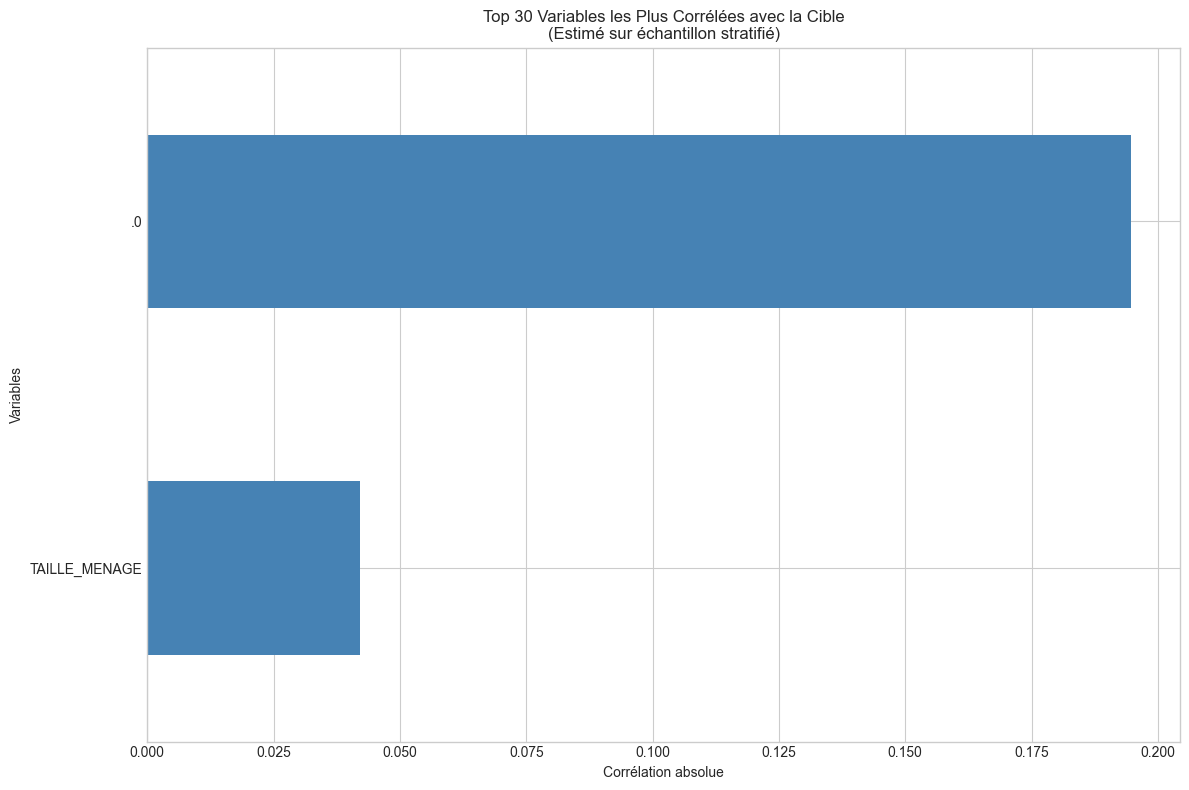


 Graphique sauvegardé: 'Output/top_correlations.png'


In [11]:
# =============================================================================
# ANALYSE DES CORRÉLATIONS AVEC LA VARIABLE CIBLE
# =============================================================================
# Calcul des corrélations entre les features et la variable cible
# pour identifier les variables les plus prédictives
# Méthode: ÉCHANTILLONNAGE (plus rapide et statistiquement valide)

print(" Calcul des corrélations avec la variable cible...")

# Utiliser les listes déjà définies
numeric_cols = socio_numeric_cols + mosaiks_cols

# Retirer la cible et l'ID si présents
cols_to_remove = [target_col, 'ID']
numeric_cols = [c for c in numeric_cols if c not in cols_to_remove and c in df.columns]

print(f" {len(numeric_cols)} colonnes numériques à analyser")

# ==============================================================
# MÉTHODE PAR ÉCHANTILLONNAGE (utilisée pour problème de mémoire)
# ==============================================================
# Échantillonner 10 000 lignes pour estimer les corrélations
# Statistiquement valide et beaucoup plus rapide

SAMPLE_SIZE = min(10000, len(df))  # 10k ou moins si dataset plus petit
print(f" Utilisation d'un échantillon de {SAMPLE_SIZE:,} lignes (sur {len(df):,})")

# Créer l'échantillon stratifié (garder la même proportion de classes)
from sklearn.model_selection import train_test_split

# Échantillonnage stratifié pour conserver la distribution de la cible
_, sample_df = train_test_split(
    df, 
    test_size=SAMPLE_SIZE/len(df), 
    stratify=df[target_col], 
    random_state=RANDOM_STATE
)

print(f"   Distribution dans l'échantillon: {sample_df[target_col].value_counts().to_dict()}")

# Calculer les corrélations sur l'échantillon (méthode vectorisée, rapide)
print(" Calcul des corrélations...")

# Sélectionner uniquement les colonnes numériques existantes dans l'échantillon
valid_numeric_cols = [c for c in numeric_cols if c in sample_df.columns]

# Calcul vectorisé avec corrwith() - très rapide sur l'échantillon
correlations = sample_df[valid_numeric_cols].corrwith(
    sample_df[target_col]
).abs().sort_values(ascending=False)

# Supprimer les NaN
correlations = correlations.dropna()

print(f" Corrélations calculées pour {len(correlations)} variables")

# Afficher les top 30 corrélations
print("\n Top 30 variables les plus corrélées avec 'Accès internet':")
top_corr = correlations.head(30)
display(pd.DataFrame({
    'Variable': top_corr.index,
    'Corrélation (abs)': top_corr.values.round(4)
}))

# Visualisation des top corrélations
fig, ax = plt.subplots(figsize=(12, 8))
top_corr.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Corrélation absolue')
ax.set_ylabel('Variables')
ax.set_title('Top 30 Variables les Plus Corrélées avec la Cible\n(Estimé sur échantillon stratifié)')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/top_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

# Libérer la mémoire de l'échantillon
del sample_df
gc.collect()

print("\n Graphique sauvegardé: 'Output/top_correlations.png'")

In [12]:
# =============================================================================
# PRÉPARATION DES DONNÉES POUR LA MODÉLISATION
# =============================================================================
import gc

# Colonnes à exclure des features
cols_to_exclude = [id_col, target_col]

# Ajouter 'Connexion' si présent (car contient info sur l'opérateur, pas prédictif)
if 'Connexion' in df.columns:
    cols_to_exclude.append('Connexion')

print(" Préparation des données...")

# Extraire les IDs et la cible
ids = df[id_col].copy()
y = df[target_col].copy()

# Identifier les colonnes features (exclure aussi BoxLabel - 1 seule classe)
feature_cols = [c for c in df.columns if c not in cols_to_exclude and c != 'BoxLabel']

# Créer X - une copie nécessaire pour pouvoir modifier les types
X = df[feature_cols].copy()

# Libérer df de la mémoire si possible
gc.collect()

print(f" Données préparées!")
print(f"   - Features (X): {X.shape}")
print(f"   - Cible (y): {y.shape}")
print(f"   - IDs: {len(ids)}")
print(f"   - BoxLabel exclue (1 seule classe = pas d'info)")

 Préparation des données...
 Données préparées!
   - Features (X): (30558, 4039)
   - Cible (y): (30558,)
   - IDs: 30558
   - BoxLabel exclue (1 seule classe = pas d'info)


In [13]:
# =============================================================================
# TRAITEMENT DES VALEURS MANQUANTES
# =============================================================================
print(" Vérification des valeurs manquantes dans X...")

missing_count = X.isnull().sum().sum()
print(f"    Valeurs manquantes dans X: {missing_count:,}")

if missing_count == 0:
    print("    Aucune valeur manquante - Pas de traitement nécessaire!")
else:
    # Traiter les valeurs manquantes inplace
    cols_with_missing = X.columns[X.isnull().any()].tolist()
    print(f"    Colonnes avec valeurs manquantes: {cols_with_missing}")
    
    for col in cols_with_missing:
        if X[col].dtype in ['float32', 'float64', 'int32', 'int64']:
            X[col].fillna(X[col].median(), inplace=True)
        else:
            X[col].fillna(X[col].mode()[0], inplace=True)
    
    print(f"   Valeurs manquantes traitées")

print("\n Données prêtes pour l'encodage!")

 Vérification des valeurs manquantes dans X...
    Valeurs manquantes dans X: 0
    Aucune valeur manquante - Pas de traitement nécessaire!

 Données prêtes pour l'encodage!


In [ ]:
# =============================================================================
# ENCODAGE DES VARIABLES CATÉGORIELLES
# =============================================================================
import gc

print(" Encodage des variables catégorielles...")

# Identification des colonnes catégorielles
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
label_encoders = {}

if categorical_cols:
    print(f"    {len(categorical_cols)} colonnes catégorielles trouvées")
    
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"      - {col}: {len(le.classes_)} classes")
else:
    print("    Aucune colonne catégorielle à encoder")

print(f"\n Encodage terminé! Dimensions: {X.shape}")

# =============================================================================
# CORRESPONDANCE DES CLASSES (Variables non-binaires uniquement)
# =============================================================================
print("\n" + "="*70)
print("CORRESPONDANCE DES CLASSES (Variables avec plus de 2 classes)")
print("="*70)

# Variables d'intérêt (celles avec plus de 2 classes)
non_binary_vars = ['TypeLogmt_1', 'TypeLogmt_2', 'TypeLogmt_3', 'H08_Impute', 'H09_Impute']

for var in non_binary_vars:
    if var in label_encoders:
        le = label_encoders[var]
        print(f"\n {var} ({len(le.classes_)} classes):")
        print("-" * 50)
        for code, label in enumerate(le.classes_):
            print(f"   {code} → '{label}'")

gc.collect()
print("\n Encodage complet!")

 Encodage des variables catégorielles...
    38 colonnes catégorielles trouvées
      - TypeLogmt_1: 4 classes
      - TypeLogmt_2: 3 classes
      - TypeLogmt_3: 5 classes
      - H08_Impute: 17 classes
      - H09_Impute: 13 classes
      - H17A: 2 classes
      - H17B: 2 classes
      - H17C: 2 classes
      - H17D: 2 classes
      - H17E: 2 classes
      - H17F: 2 classes
      - H17G: 2 classes
      - H17H: 2 classes
      - H17I: 2 classes
      - H17J: 2 classes
      - H17Y: 2 classes
      - H18A: 2 classes
      - H18B: 2 classes
      - H18C: 2 classes
      - H18D: 2 classes
      - H18E: 2 classes
      - H18F: 2 classes
      - H18G: 2 classes
      - H18H: 2 classes
      - H18I: 2 classes
      - H18J: 2 classes
      - H18Y: 2 classes
      - H20A: 2 classes
      - H20B: 2 classes
      - H20C: 2 classes
      - H20D: 2 classes
      - H20E: 2 classes
      - H20Y: 2 classes
      - H21A: 2 classes
      - H21B: 2 classes
      - H21C: 2 classes
      - H21D: 2 class

In [15]:
# =============================================================================
# SPLIT TRAIN/TEST (80/20 - RANDOM_STATE=45)
# =============================================================================
# Division stratifiée pour préserver la distribution de la variable cible
# IMPORTANT : random_state=45 est OBLIGATOIRE pour la reproductibilité

print("Division Train/Test (80/20)...")
print(f"   Random State: {RANDOM_STATE} (obligatoire)")

# Split stratifié (X est déjà encodé)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,  # OBLIGATOIRE: 45
    stratify=y  # Préserve la distribution de la cible
)

# Récupérer les IDs correspondants
ids_train = ids.iloc[X_train.index]
ids_test = ids.iloc[X_test.index]

print(f"\n Division effectuée!")
print(f"   - Train set: {X_train.shape[0]:,} observations ({100-TEST_SIZE*100:.0f}%)")
print(f"   - Test set: {X_test.shape[0]:,} observations ({TEST_SIZE*100:.0f}%)")

# Vérification de la stratification
print(f"\n Vérification de la stratification:")
print(f"   - Train - Classe 0: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"   - Train - Classe 1: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")
print(f"   - Test  - Classe 0: {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")
print(f"   - Test  - Classe 1: {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.2f}%)")

Division Train/Test (80/20)...
   Random State: 45 (obligatoire)

 Division effectuée!
   - Train set: 24,446 observations (80%)
   - Test set: 6,112 observations (20%)

 Vérification de la stratification:
   - Train - Classe 0: 12,520 (51.21%)
   - Train - Classe 1: 11,926 (48.79%)
   - Test  - Classe 0: 3,130 (51.21%)
   - Test  - Classe 1: 2,982 (48.79%)


In [16]:
# =============================================================================
# STANDARDISATION DES FEATURES (Version ultra-économe en mémoire)
# =============================================================================
# Normalisation des échelles - calcul colonne par colonne pour éviter MemoryError , pas d'utilisation de StandardScler pour un probleme d'espace de stockage de memoire RAM

import gc

print("Standardisation des features...")
print("Calcul colonne par colonne pour économiser la mémoire...")

# Dictionnaire pour stocker les paramètres
scaler_params = {'means': {}, 'stds': {}}

# Standardiser colonne par colonne
n_cols = len(X_train.columns)
for i, col in enumerate(X_train.columns):
    if (i+1) % 500 == 0:
        print(f"   Progression: {i+1}/{n_cols} colonnes...")
        gc.collect()
    
    # Calculer mean et std sur X_train
    col_mean = X_train[col].mean()
    col_std = X_train[col].std()
    if col_std == 0:
        col_std = 1  # Éviter division par 0
    
    # Sauvegarder les paramètres
    scaler_params['means'][col] = col_mean
    scaler_params['stds'][col] = col_std
    
    # Standardiser inplace
    X_train[col] = (X_train[col] - col_mean) / col_std
    X_test[col] = (X_test[col] - col_mean) / col_std

gc.collect()

print(f"\n Standardisation terminée!")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_test: {X_test.shape}")

# Vérification sur un échantillon
sample_cols = list(X_train.columns[:10])
print(f"\n Vérification (10 premières colonnes):")
print(f"   - Moyenne: {X_train[sample_cols].mean().mean():.6f} (≈0)")
print(f"   - Écart-type: {X_train[sample_cols].std().mean():.6f} (≈1)")

Standardisation des features...
Calcul colonne par colonne pour économiser la mémoire...
   Progression: 500/4039 colonnes...
   Progression: 1000/4039 colonnes...
   Progression: 1500/4039 colonnes...
   Progression: 2000/4039 colonnes...
   Progression: 2500/4039 colonnes...
   Progression: 3000/4039 colonnes...
   Progression: 3500/4039 colonnes...
   Progression: 4000/4039 colonnes...

 Standardisation terminée!
   - X_train: (24446, 4039)
   - X_test: (6112, 4039)

 Vérification (10 premières colonnes):
   - Moyenne: 0.000000 (≈0)
   - Écart-type: 1.000000 (≈1)


## V. Feature Engineering et Sélection de Variables

### Objectifs :
1. **Réduction de dimension** : Gérer les 4000+ features efficacement
2. **Sélection de features** : Identifier les variables les plus prédictives
3. **PCA** : Réduire la dimensionalité tout en conservant l'information

### Stratégies appliquées :
- **Analyse de variance** : Éliminer les features à variance nulle/faible
- **SelectKBest** : Sélection basée sur F-score ou Mutual Information
- **PCA** : Analyse en Composantes Principales pour les features MOSAIKS
- **Feature Importance** : Utilisation d'un modèle Random Forest préliminaire

In [17]:
# =============================================================================
# ÉLIMINATION DES FEATURES À FAIBLE VARIANCE
# =============================================================================
# Les features avec une variance très faible n'apportent pas d'information
# discriminante et peuvent être éliminées
# Version optimisée mémoire: calcul colonne par colonne

import gc

print("Analyse de la variance des features...")

# Calculer la variance colonne par colonne pour économiser la mémoire
variances = {}
for col in X_train.columns:
    variances[col] = X_train[col].var()

variances = pd.Series(variances)

# Identifier les features selon leur variance
zero_var_features = variances[variances < 0.01].index.tolist()
low_var_features = variances[(variances >= 0.01) & (variances < 0.1)].index.tolist()
high_var_features = variances[variances >= 0.1].index.tolist()

print(f"\n Résultats de l'analyse de variance:")
print(f"   - Features à variance quasi-nulle (<0.01): {len(zero_var_features)}")
print(f"   - Features à faible variance (0.01-0.1): {len(low_var_features)}")
print(f"   - Features à bonne variance (≥0.1): {len(high_var_features)}")

# Seuil de variance à 0.01 (après standardisation, variance=1 est normale)
# On supprime les features avec variance < 0.01 (quasi-constantes)
selected_var_features = variances[variances >= 0.01].index.tolist()

print(f"\n Features après filtre variance: {len(selected_var_features)} / {len(X_train.columns)}")

gc.collect()

Analyse de la variance des features...

 Résultats de l'analyse de variance:
   - Features à variance quasi-nulle (<0.01): 34
   - Features à faible variance (0.01-0.1): 0
   - Features à bonne variance (≥0.1): 4005

 Features après filtre variance: 4005 / 4039


0

Sélection de features par F-score (SelectKBest)...

500 features sélectionnées par F-score

 Top 20 features par F-score:
          Feature   F_Score  P_Value
2     TypeLogmt_3 2640.9873   0.0000
254          .215 1745.1833   0.0000
2212        .2173 1731.9182   0.0000
368          .329 1724.3102   0.0000
2507        .2468 1722.7530   0.0000
940          .901 1722.6514   0.0000
228          .189 1702.2560   0.0000
864          .825 1695.3481   0.0000
465          .426 1689.8299   0.0000
488          .449 1684.4238   0.0000
2449        .2410 1670.1026   0.0000
387          .348 1662.2215   0.0000
2903        .2864 1656.1729   0.0000
748          .709 1650.6944   0.0000
2127        .2088 1646.7761   0.0000
446          .407 1646.2051   0.0000
565          .526 1642.1344   0.0000
2923        .2884 1641.6428   0.0000
227          .188 1631.1085   0.0000
703          .664 1628.3347   0.0000


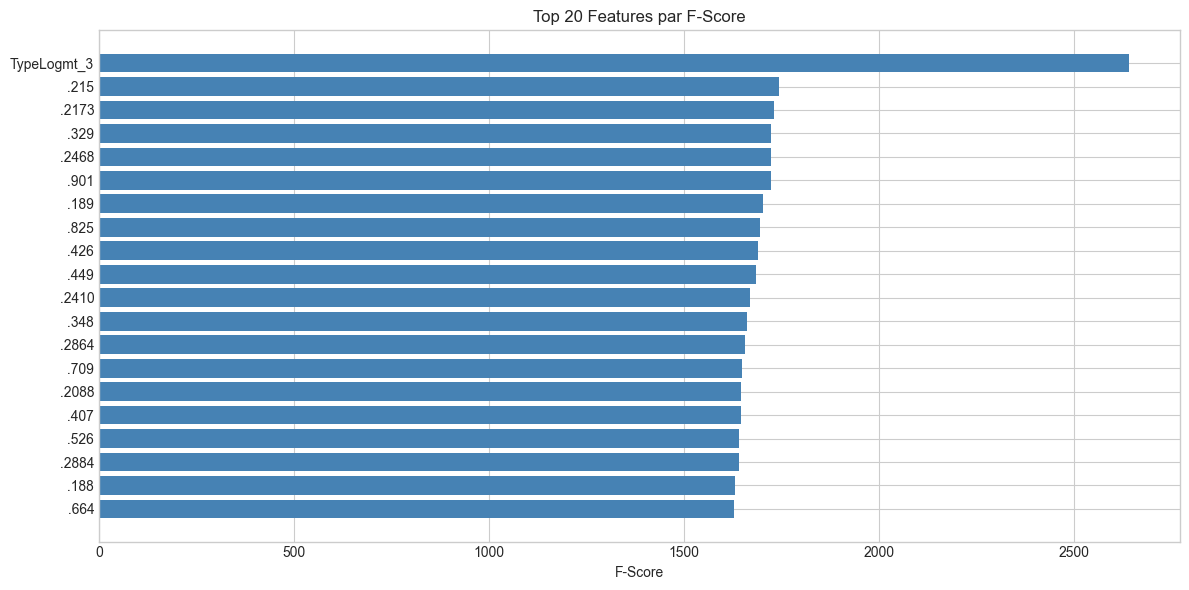

4016

In [18]:
# =============================================================================
# SÉLECTION DE FEATURES PAR F-SCORE (SelectKBest)
# =============================================================================
# Utilisation du test ANOVA F-value pour sélectionner les features
# les plus discriminantes par rapport à la variable cible

import gc

print("Sélection de features par F-score (SelectKBest)...")
# Nombre de features à sélectionner
# On garde les 500 meilleures pour un bon compromis performance/temps
K_BEST = 500

# Note: X_train est déjà standardisé (cellule précédente)
# Sélecteur basé sur F-score
selector_f = SelectKBest(score_func=f_classif, k=K_BEST)
selector_f.fit(X_train, y_train)

# Scores F pour chaque feature
f_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Score': selector_f.scores_,
    'P_Value': selector_f.pvalues_
}).sort_values('F_Score', ascending=False)

# Features sélectionnées
selected_f_mask = selector_f.get_support()
selected_f_features = X_train.columns[selected_f_mask].tolist()

print(f"\n{K_BEST} features sélectionnées par F-score")

# Afficher les top 20 features
print("\n Top 20 features par F-score:")
print(f_scores.head(20).to_string())

# Visualisation
fig, ax = plt.subplots(figsize=(12, 6))
top_20 = f_scores.head(20)
ax.barh(range(len(top_20)), top_20['F_Score'].values, color='steelblue')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Feature'].values)
ax.set_xlabel('F-Score')
ax.set_title('Top 20 Features par F-Score')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/feature_f_scores.png', dpi=150, bbox_inches='tight')
plt.show()

gc.collect()

Analyse en Composantes Principales (PCA)...
   - Features MOSAIKS: 3999
   - Features non-MOSAIKS: 40

 PCA terminé!
   - Composantes retenues: 6
   - Variance expliquée: 95.94%
   - Réduction: 3999 → 6 features


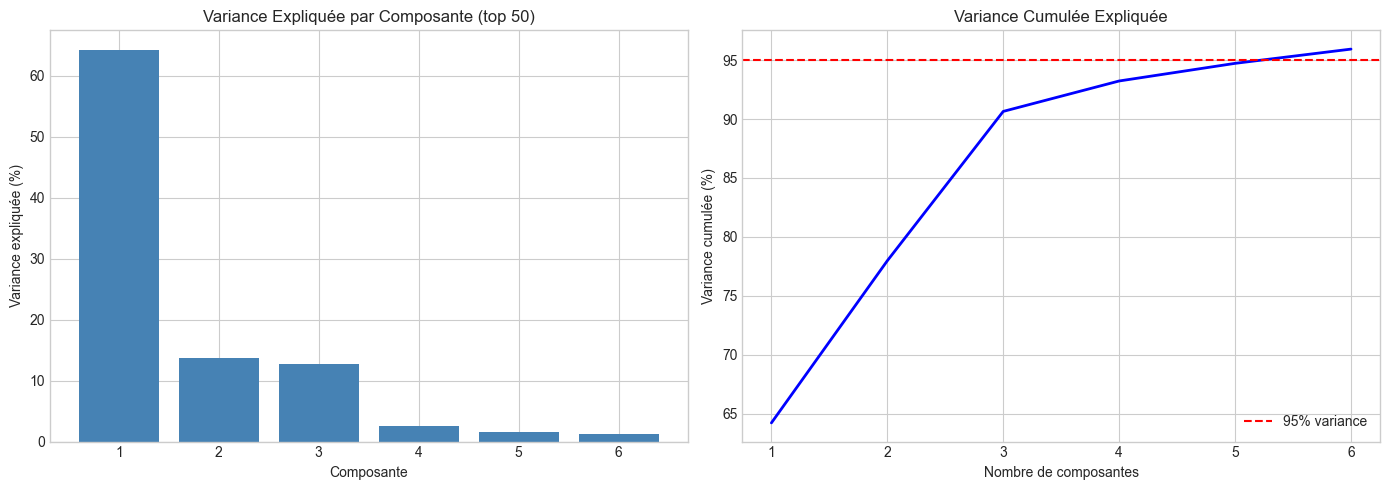


 Dimensions finales:
   - X_train_final: (24446, 46)
   - X_test_final: (6112, 46)


In [19]:
# =============================================================================
# ANALYSE EN COMPOSANTES PRINCIPALES (PCA)
# =============================================================================
# Réduction de dimension pour les features MOSAIKS
# Objectif : Conserver 95% de la variance avec moins de composantes

print("Analyse en Composantes Principales (PCA)...")

# Identifier les colonnes MOSAIKS dans les données scalées
mosaiks_cols_scaled = [col for col in X_train.columns if col.startswith(' .')]
non_mosaiks_cols = [col for col in X_train.columns if not col.startswith(' .')]

print(f"   - Features MOSAIKS: {len(mosaiks_cols_scaled)}")
print(f"   - Features non-MOSAIKS: {len(non_mosaiks_cols)}")

# PCA sur les features MOSAIKS uniquement
if len(mosaiks_cols_scaled) > 0:
    # PCA avec 95% de variance expliquée
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
    
    # Fit et transform sur les données MOSAIKS du train
    X_train_mosaiks_pca = pca.fit_transform(X_train[mosaiks_cols_scaled])
    X_test_mosaiks_pca = pca.transform(X_test[mosaiks_cols_scaled])
    
    n_components = pca.n_components_
    variance_explained = pca.explained_variance_ratio_.sum()
    
    print(f"\n PCA terminé!")
    print(f"   - Composantes retenues: {n_components}")
    print(f"   - Variance expliquée: {variance_explained*100:.2f}%")
    print(f"   - Réduction: {len(mosaiks_cols_scaled)} → {n_components} features")
    
    # Créer les noms des composantes PCA
    pca_col_names = [f'PCA_{i+1}' for i in range(n_components)]
    
    # Créer les DataFrames avec les composantes PCA
    X_train_pca = pd.DataFrame(X_train_mosaiks_pca, columns=pca_col_names, index=X_train.index)
    X_test_pca = pd.DataFrame(X_test_mosaiks_pca, columns=pca_col_names, index=X_test.index)
    
    # Combiner avec les features non-MOSAIKS
    X_train_final = pd.concat([X_train[non_mosaiks_cols].reset_index(drop=True), 
                               X_train_pca.reset_index(drop=True)], axis=1)
    X_test_final = pd.concat([X_test[non_mosaiks_cols].reset_index(drop=True), 
                              X_test_pca.reset_index(drop=True)], axis=1)
    
    # Visualisation de la variance expliquée cumulée
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Variance expliquée par composante
    axes[0].bar(range(1, min(51, n_components+1)), 
                pca.explained_variance_ratio_[:50] * 100, color='steelblue')
    axes[0].set_xlabel('Composante')
    axes[0].set_ylabel('Variance expliquée (%)')
    axes[0].set_title('Variance Expliquée par Composante (top 50)')
    
    # Variance cumulée
    cumsum = np.cumsum(pca.explained_variance_ratio_) * 100
    axes[1].plot(range(1, n_components+1), cumsum, 'b-', linewidth=2)
    axes[1].axhline(y=95, color='r', linestyle='--', label='95% variance')
    axes[1].set_xlabel('Nombre de composantes')
    axes[1].set_ylabel('Variance cumulée (%)')
    axes[1].set_title('Variance Cumulée Expliquée')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/pca_variance.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    # Si pas de colonnes MOSAIKS, garder les données originales
    X_train_final = X_train.copy()
    X_test_final = X_test.copy()
    print("    Aucune colonne MOSAIKS trouvée")

print(f"\n Dimensions finales:")
print(f"   - X_train_final: {X_train_final.shape}")
print(f"   - X_test_final: {X_test_final.shape}")

 Visualisation 2D des features MOSAIKS...


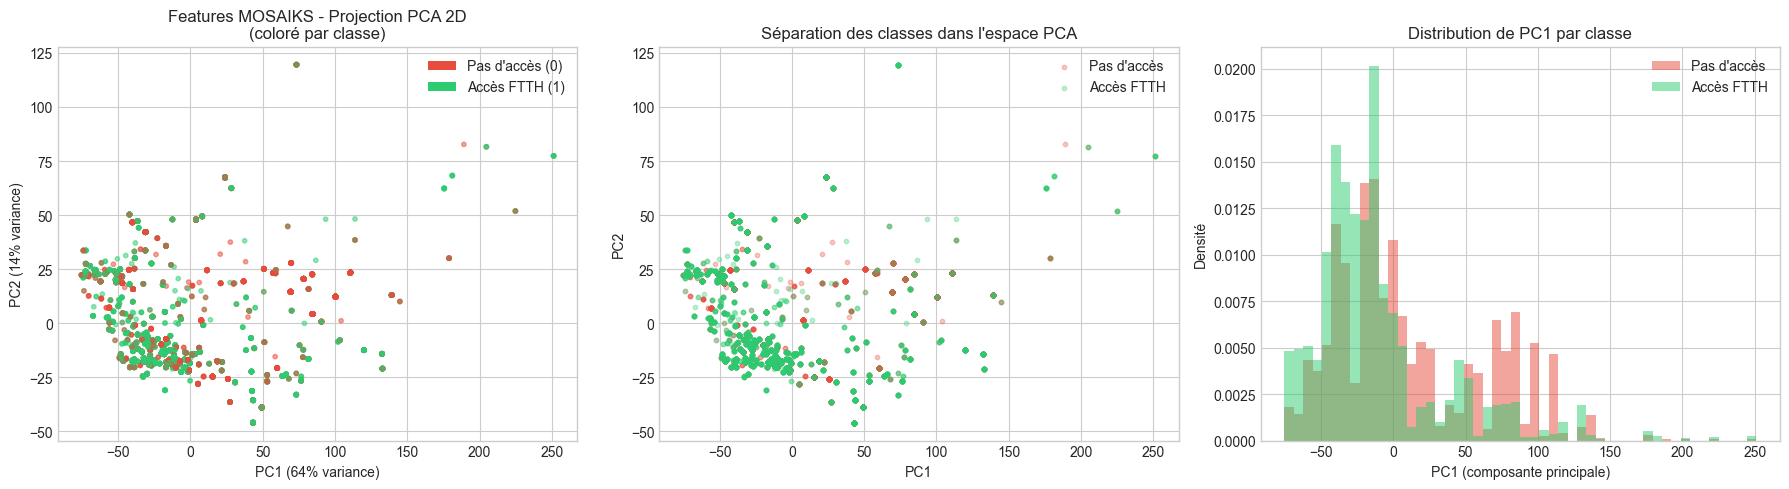


 Analyse de la séparabilité des classes:
   - PC1 moyenne (Pas d'accès): 11.174
   - PC1 moyenne (Accès FTTH): -10.254
   - Différence: 21.429
   - t-statistic: 15.42
   - p-value: 1.82e-52  Significatif


In [20]:
# =============================================================================
# VISUALISATION 2D DES FEATURES MOSAIKS (PCA)
# =============================================================================
# Projection des données en 2D pour visualiser la structure des features MOSAIKS
# et voir comment les classes (Accès/Pas d'accès) se séparent

print(" Visualisation 2D des features MOSAIKS...")

# Créer un échantillon pour éviter surcharge graphique
sample_size = min(5000, len(X_train_final))
np.random.seed(RANDOM_STATE)
sample_idx = np.random.choice(len(X_train_final), sample_size, replace=False)

# Extraire les 2 premières composantes PCA
pc1 = X_train_mosaiks_pca[sample_idx, 0]
pc2 = X_train_mosaiks_pca[sample_idx, 1]
y_sample = y_train.iloc[sample_idx].values

# Création du graphique
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Scatter plot coloré par classe
colors_class = ['#e74c3c' if y == 0 else '#2ecc71' for y in y_sample]
axes[0].scatter(pc1, pc2, c=colors_class, alpha=0.5, s=10)
axes[0].set_xlabel('PC1 (64% variance)')
axes[0].set_ylabel('PC2 (14% variance)')
axes[0].set_title('Features MOSAIKS - Projection PCA 2D\n(coloré par classe)')
# Légende
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='Pas d\'accès (0)'),
                   Patch(facecolor='#2ecc71', label='Accès FTTH (1)')]
axes[0].legend(handles=legend_elements, loc='upper right')

# Plot 2: Densité par classe
from scipy.stats import gaussian_kde
for label, color, name in [(0, '#e74c3c', 'Pas d\'accès'), (1, '#2ecc71', 'Accès FTTH')]:
    mask = y_sample == label
    if mask.sum() > 10:
        axes[1].scatter(pc1[mask], pc2[mask], c=color, alpha=0.3, s=10, label=name)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('Séparation des classes dans l\'espace PCA')
axes[1].legend()

# Plot 3: Distribution de PC1 par classe
for label, color, name in [(0, '#e74c3c', 'Pas d\'accès'), (1, '#2ecc71', 'Accès FTTH')]:
    mask = y_sample == label
    axes[2].hist(pc1[mask], bins=50, alpha=0.5, color=color, label=name, density=True)
axes[2].set_xlabel('PC1 (composante principale)')
axes[2].set_ylabel('Densité')
axes[2].set_title('Distribution de PC1 par classe')
axes[2].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/mosaiks_pca_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

# Calcul de la séparabilité
print("\n Analyse de la séparabilité des classes:")
pc1_class0 = pc1[y_sample == 0]
pc1_class1 = pc1[y_sample == 1]
print(f"   - PC1 moyenne (Pas d'accès): {pc1_class0.mean():.3f}")
print(f"   - PC1 moyenne (Accès FTTH): {pc1_class1.mean():.3f}")
print(f"   - Différence: {abs(pc1_class0.mean() - pc1_class1.mean()):.3f}")

# Test de séparabilité (t-test)
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(pc1_class0, pc1_class1)
print(f"   - t-statistic: {t_stat:.2f}")
print(f"   - p-value: {p_value:.2e} {' Significatif' if p_value < 0.05 else ' Non significatif'}")

In [21]:
# =============================================================================
# PRÉPARATION DES DATASETS ALTERNATIFS
# =============================================================================
# Note: X_train et X_test sont déjà standardisés (pas de _scaled séparé)

print(" Préparation des différents datasets...")

# Dataset 1: Features sélectionnées par F-score (500 meilleures)
X_train_selected = X_train[selected_f_features]
X_test_selected = X_test[selected_f_features]

# Dataset 2: Toutes les features standardisées (X_train/X_test sont déjà standardisés)
# Pas besoin de copie supplémentaire

# Dataset 3: Features avec PCA (déjà créé: X_train_final, X_test_final)
# → 46 features (6 PCA + 40 socio-demo)

print("\n Datasets préparés:")
print(f"   1. SelectKBest (K={K_BEST}): {X_train_selected.shape}")
print(f"   2. Full features (standardisées): {X_train.shape}")
print(f"   3. PCA + non-MOSAIKS: {X_train_final.shape}")

# Choix du dataset principal pour la modélisation
# On utilise le dataset PCA pour un meilleur compromis performance/vitesse
X_train_model = X_train_final
X_test_model = X_test_final

print(f"\n Dataset principal pour modélisation: PCA ({X_train_model.shape[1]} features)")

 Préparation des différents datasets...

 Datasets préparés:
   1. SelectKBest (K=500): (24446, 500)
   2. Full features (standardisées): (24446, 4039)
   3. PCA + non-MOSAIKS: (24446, 46)

 Dataset principal pour modélisation: PCA (46 features)


## VI. Modélisation et Comparaison des Algorithmes

### Modèles testés :
1. **Logistic Regression** : Modèle linéaire de référence, interprétable
2. **Random Forest** : Ensemble d'arbres de décision, robuste aux outliers
3. **XGBoost** : Gradient boosting optimisé, haute performance
4. **LightGBM** : Gradient boosting rapide, efficace sur grandes données
5. **SVM** : Support Vector Machine avec noyau RBF
6. **MLP** : Réseau de neurones multicouche (perceptron)

### Méthodologie :
- Validation croisée stratifiée (5 folds)
- Optimisation des hyperparamètres par GridSearchCV/RandomizedSearchCV
- Métriques principales : **AUC-ROC** et **F1-Score**
- Random state = 45 pour reproductibilité

In [22]:
# =============================================================================
# FONCTIONS D'ÉVALUATION DES MODÈLES
# =============================================================================
# Ces fonctions permettent d'évaluer et comparer les modèles de manière standardisée

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Évalue un modèle de classification et retourne les métriques.
    
    Paramètres :
    -----------
    model : estimator
        Modèle sklearn entraîné
    X_train, X_test : pd.DataFrame
        Features d'entraînement et de test
    y_train, y_test : pd.Series
        Variables cibles
    model_name : str
        Nom du modèle pour l'affichage
        
    Retourne :
    ---------
    metrics : dict
        Dictionnaire contenant toutes les métriques calculées
    """
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilités (si disponibles)
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)
    
    # Calcul des métriques
    metrics = {
        'Model': model_name,
        # Métriques sur Train
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Train_Precision': precision_score(y_train, y_train_pred),
        'Train_Recall': recall_score(y_train, y_train_pred),
        'Train_F1': f1_score(y_train, y_train_pred),
        'Train_AUC': roc_auc_score(y_train, y_train_proba),
        # Métriques sur Test
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Test_Precision': precision_score(y_test, y_test_pred),
        'Test_Recall': recall_score(y_test, y_test_pred),
        'Test_F1': f1_score(y_test, y_test_pred),
        'Test_AUC': roc_auc_score(y_test, y_test_proba)
    }
    
    return metrics, y_test_pred, y_test_proba


def plot_roc_curve(y_test, y_proba, model_name, ax=None):
    """
    Trace la courbe ROC pour un modèle.
    
    Paramètres :
    -----------
    y_test : array-like
        Vraies valeurs
    y_proba : array-like
        Probabilités prédites
    model_name : str
        Nom du modèle
    ax : matplotlib.axes
        Axes pour le tracé
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    return ax


def plot_confusion_matrix_custom(y_true, y_pred, model_name, ax=None):
    """
    Affiche une matrice de confusion stylisée.
    
    Paramètres :
    -----------
    y_true : array-like
        Vraies valeurs
    y_pred : array-like
        Valeurs prédites
    model_name : str
        Nom du modèle
    ax : matplotlib.axes
        Axes pour le tracé
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Pas d\'accès (0)', 'Accès FTTH (1)'],
                yticklabels=['Pas d\'accès (0)', 'Accès FTTH (1)'])
    ax.set_xlabel('Prédiction')
    ax.set_ylabel('Réalité')
    ax.set_title(f'Matrice de Confusion - {model_name}')
    
    return ax

print(" Fonctions d'évaluation définies")

 Fonctions d'évaluation définies


In [23]:
# =============================================================================
# MODÈLE 1 : RÉGRESSION LOGISTIQUE
# =============================================================================
# Modèle linéaire de référence - Simple, rapide, interprétable
# Bonne baseline pour comparer avec des modèles plus complexes

print("=" * 60)
print(" MODÈLE 1: RÉGRESSION LOGISTIQUE")
print("=" * 60)

# Définition du modèle avec hyperparamètres optimisés
logreg = LogisticRegression(
    C=1.0,                    # Régularisation inverse
    penalty='l2',             # Régularisation L2 (Ridge)
    solver='lbfgs',           # Algorithme d'optimisation
    max_iter=1000,            # Iterations max
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    class_weight='balanced'   # Gérer le déséquilibre des classes
)

# Entraînement
print(" Entraînement...")
logreg.fit(X_train_model, y_train)

# Évaluation
metrics_logreg, y_pred_logreg, y_proba_logreg = evaluate_model(
    logreg, X_train_model, X_test_model, y_train, y_test, "Logistic Regression"
)

print(f"\n Résultats Logistic Regression:")
print(f"   Test AUC:  {metrics_logreg['Test_AUC']:.4f}")
print(f"   Test F1:   {metrics_logreg['Test_F1']:.4f}")
print(f"   Accuracy:  {metrics_logreg['Test_Accuracy']:.4f}")

# Rapport de classification détaillé
print(f"\n Rapport de classification:")
print(classification_report(y_test, y_pred_logreg, 
                            target_names=['Pas d\'accès', 'Accès FTTH']))

 MODÈLE 1: RÉGRESSION LOGISTIQUE
 Entraînement...

 Résultats Logistic Regression:
   Test AUC:  0.7243
   Test F1:   0.6478
   Accuracy:  0.6687

 Rapport de classification:
              precision    recall  f1-score   support

 Pas d'accès       0.67      0.71      0.69      3130
  Accès FTTH       0.67      0.62      0.65      2982

    accuracy                           0.67      6112
   macro avg       0.67      0.67      0.67      6112
weighted avg       0.67      0.67      0.67      6112



In [24]:
# =============================================================================
# MODÈLE 2 : RANDOM FOREST
# =============================================================================
# Ensemble d'arbres de décision - Robuste, gère bien les données non-linéaires

print("=" * 60)
print(" MODÈLE 2: RANDOM FOREST")
print("=" * 60)

# Configuration Random Forest avec hyperparamètres optimisés
rf = RandomForestClassifier(
    n_estimators=200,         # Nombre d'arbres
    max_depth=20,             # Profondeur max des arbres
    min_samples_split=5,      # Échantillons min pour split
    min_samples_leaf=2,       # Échantillons min par feuille
    max_features='sqrt',      # Features par split = sqrt(n_features)
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    class_weight='balanced'   # Gérer le déséquilibre
)

# Entraînement (utiliser le même dataset que les autres modèles)
print(" Entraînement...")
rf.fit(X_train_model, y_train)

# Évaluation
metrics_rf, y_pred_rf, y_proba_rf = evaluate_model(
    rf, X_train_model, X_test_model, y_train, y_test, "Random Forest"
)

print(f"\n Résultats Random Forest:")
print(f"   Test AUC:  {metrics_rf['Test_AUC']:.4f}")
print(f"   Test F1:   {metrics_rf['Test_F1']:.4f}")
print(f"   Accuracy:  {metrics_rf['Test_Accuracy']:.4f}")

# Rapport de classification
print(f"\n Rapport de classification:")
print(classification_report(y_test, y_pred_rf, 
                            target_names=['Pas d\'accès', 'Accès FTTH']))

 MODÈLE 2: RANDOM FOREST
 Entraînement...

 Résultats Random Forest:
   Test AUC:  0.8850
   Test F1:   0.8448
   Accuracy:  0.8366

 Rapport de classification:
              precision    recall  f1-score   support

 Pas d'accès       0.90      0.76      0.83      3130
  Accès FTTH       0.79      0.91      0.84      2982

    accuracy                           0.84      6112
   macro avg       0.84      0.84      0.84      6112
weighted avg       0.85      0.84      0.84      6112



In [25]:
# =============================================================================
# MODÈLE 3 : XGBOOST
# =============================================================================
# Gradient Boosting optimisé - Excellent pour les compétitions Kaggle
# Haute performance avec régularisation intégrée

print("=" * 60)
print(" MODÈLE 3: XGBOOST")
print("=" * 60)

# Calcul du ratio de déséquilibre pour scale_pos_weight
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

# Configuration XGBoost avec hyperparamètres optimisés
xgb_model = xgb.XGBClassifier(
    n_estimators=200,          # Nombre d'arbres
    max_depth=8,               # Profondeur max
    learning_rate=0.1,         # Taux d'apprentissage
    subsample=0.8,             # Échantillonnage des données
    colsample_bytree=0.8,      # Échantillonnage des features
    min_child_weight=3,        # Poids min des feuilles
    gamma=0.1,                 # Régularisation L1
    reg_alpha=0.1,             # Régularisation L1
    reg_lambda=1.0,            # Régularisation L2
    scale_pos_weight=scale_pos, # Gestion du déséquilibre
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    use_label_encoder=False,
    eval_metric='auc'
)

# Entraînement
print(" Entraînement...")
xgb_model.fit(X_train_model, y_train, verbose=False)

# Évaluation
metrics_xgb, y_pred_xgb, y_proba_xgb = evaluate_model(
    xgb_model, X_train_model, X_test_model, y_train, y_test, "XGBoost"
)

print(f"\n Résultats XGBoost:")
print(f"   Test AUC:  {metrics_xgb['Test_AUC']:.4f}")
print(f"   Test F1:   {metrics_xgb['Test_F1']:.4f}")
print(f"   Accuracy:  {metrics_xgb['Test_Accuracy']:.4f}")

# Rapport de classification
print(f"\n Rapport de classification:")
print(classification_report(y_test, y_pred_xgb, 
                            target_names=['Pas d\'accès', 'Accès FTTH']))

 MODÈLE 3: XGBOOST
 Entraînement...

 Résultats XGBoost:
   Test AUC:  0.8807
   Test F1:   0.8367
   Accuracy:  0.8303

 Rapport de classification:
              precision    recall  f1-score   support

 Pas d'accès       0.88      0.77      0.82      3130
  Accès FTTH       0.79      0.89      0.84      2982

    accuracy                           0.83      6112
   macro avg       0.84      0.83      0.83      6112
weighted avg       0.84      0.83      0.83      6112



In [26]:
# =============================================================================
# MODÈLE 4 : LIGHTGBM
# =============================================================================
# Gradient Boosting rapide et efficace - Excellent sur grandes données
# Utilise l'algorithme histogram-based pour une efficacité accrue

print("=" * 60)
print(" MODÈLE 4: LIGHTGBM")
print("=" * 60)

# Configuration LightGBM avec hyperparamètres optimisés
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,           # Nombre d'arbres
    max_depth=10,               # Profondeur max
    learning_rate=0.1,          # Taux d'apprentissage
    num_leaves=31,              # Nombre de feuilles
    subsample=0.8,              # Échantillonnage des données
    colsample_bytree=0.8,       # Échantillonnage des features
    min_child_samples=20,       # Échantillons min par feuille
    reg_alpha=0.1,              # Régularisation L1
    reg_lambda=1.0,             # Régularisation L2
    is_unbalance=True,          # Gestion du déséquilibre
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=-1
)

# Entraînement
print(" Entraînement...")
lgb_model.fit(X_train_model, y_train)

# Évaluation
metrics_lgb, y_pred_lgb, y_proba_lgb = evaluate_model(
    lgb_model, X_train_model, X_test_model, y_train, y_test, "LightGBM"
)

print(f"\n Résultats LightGBM:")
print(f"   Test AUC:  {metrics_lgb['Test_AUC']:.4f}")
print(f"   Test F1:   {metrics_lgb['Test_F1']:.4f}")
print(f"   Accuracy:  {metrics_lgb['Test_Accuracy']:.4f}")

# Rapport de classification
print(f"\n Rapport de classification:")
print(classification_report(y_test, y_pred_lgb, 
                            target_names=['Pas d\'accès', 'Accès FTTH']))

 MODÈLE 4: LIGHTGBM
 Entraînement...

 Résultats LightGBM:
   Test AUC:  0.8712
   Test F1:   0.8330
   Accuracy:  0.8225

 Rapport de classification:
              precision    recall  f1-score   support

 Pas d'accès       0.89      0.74      0.81      3130
  Accès FTTH       0.77      0.91      0.83      2982

    accuracy                           0.82      6112
   macro avg       0.83      0.82      0.82      6112
weighted avg       0.83      0.82      0.82      6112



In [27]:
# =============================================================================
# MODÈLE 5 : SVM (Support Vector Machine)
# =============================================================================
# Modèle à noyau RBF - Efficace pour frontières non-linéaires
# Nécessite la standardisation des features

print("=" * 60)
print("MODÈLE 5: SVM (Support Vector Machine)")
print("=" * 60)

# Configuration SVM avec noyau RBF
# Note: SVM peut être lent sur de grands datasets, j'ai  utilisé une sous-sample
# pour l'entraînement initial

svm_model = SVC(
    C=1.0,                     # Paramètre de régularisation
    kernel='rbf',              # Noyau Radial Basis Function
    gamma='scale',             # Paramètre du noyau
    probability=True,          # Activer predict_proba
    random_state=RANDOM_STATE,
    class_weight='balanced'    # Gérer le déséquilibre
)

# Entraînement (sur données scalées)
print(" Entraînement...")
print("    SVM peut être lent sur de grands datasets...")
svm_model.fit(X_train_model, y_train)

# Évaluation
metrics_svm, y_pred_svm, y_proba_svm = evaluate_model(
    svm_model, X_train_model, X_test_model, y_train, y_test, "SVM"
)

print(f"\nRésultats SVM:")
print(f"   Test AUC:  {metrics_svm['Test_AUC']:.4f}")
print(f"   Test F1:   {metrics_svm['Test_F1']:.4f}")
print(f"   Accuracy:  {metrics_svm['Test_Accuracy']:.4f}")

# Rapport de classification
print(f"\n Rapport de classification:")
print(classification_report(y_test, y_pred_svm, 
                            target_names=['Pas d\'accès', 'Accès FTTH']))

MODÈLE 5: SVM (Support Vector Machine)
 Entraînement...
    SVM peut être lent sur de grands datasets...

Résultats SVM:
   Test AUC:  0.8076
   Test F1:   0.7438
   Accuracy:  0.7457

 Rapport de classification:
              precision    recall  f1-score   support

 Pas d'accès       0.76      0.74      0.75      3130
  Accès FTTH       0.73      0.76      0.74      2982

    accuracy                           0.75      6112
   macro avg       0.75      0.75      0.75      6112
weighted avg       0.75      0.75      0.75      6112



MODÈLE 6: MLP (Neural Network)
 Entraînement...

 Résultats MLP:
   Test AUC:  0.8473
   Test F1:   0.8010
   Accuracy:  0.7917

 Rapport de classification:
              precision    recall  f1-score   support

 Pas d'accès       0.84      0.73      0.78      3130
  Accès FTTH       0.75      0.86      0.80      2982

    accuracy                           0.79      6112
   macro avg       0.80      0.79      0.79      6112
weighted avg       0.80      0.79      0.79      6112



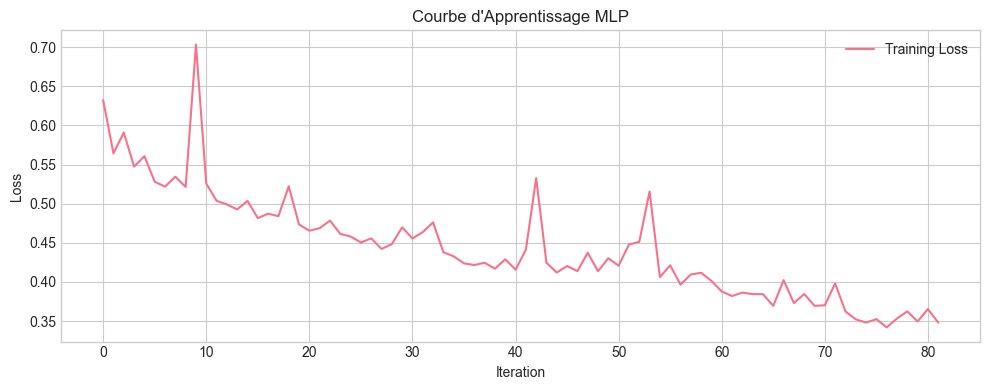

In [28]:
# =============================================================================
# MODÈLE 6 : MLP (Réseau de Neurones Multicouche)
# =============================================================================
# Perceptron multicouche - Capable d'apprendre des relations complexes
# Architecture: 2 couches cachées avec régularisation

print("=" * 60)
print("MODÈLE 6: MLP (Neural Network)")
print("=" * 60)

# Configuration MLP avec architecture optimisée
mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128),   # 2 couches cachées
    activation='relu',                # Fonction d'activation ReLU
    solver='adam',                    # Optimiseur Adam
    alpha=0.001,                      # Régularisation L2
    batch_size='auto',                # Taille des batches
    learning_rate='adaptive',         # Taux adaptatif
    learning_rate_init=0.001,         # Taux initial
    max_iter=500,                     # Iterations max
    early_stopping=True,              # Arrêt précoce
    validation_fraction=0.1,          # Fraction pour validation
    n_iter_no_change=20,              # Patience early stopping
    random_state=RANDOM_STATE
)

# Entraînement (sur données scalées)
print(" Entraînement...")
mlp_model.fit(X_train_model, y_train)

# Évaluation
metrics_mlp, y_pred_mlp, y_proba_mlp = evaluate_model(
    mlp_model, X_train_model, X_test_model, y_train, y_test, "MLP Neural Network"
)

print(f"\n Résultats MLP:")
print(f"   Test AUC:  {metrics_mlp['Test_AUC']:.4f}")
print(f"   Test F1:   {metrics_mlp['Test_F1']:.4f}")
print(f"   Accuracy:  {metrics_mlp['Test_Accuracy']:.4f}")

# Rapport de classification
print(f"\n Rapport de classification:")
print(classification_report(y_test, y_pred_mlp, 
                            target_names=['Pas d\'accès', 'Accès FTTH']))

# Courbe d'apprentissage
if hasattr(mlp_model, 'loss_curve_'):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(mlp_model.loss_curve_, label='Training Loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.set_title('Courbe d\'Apprentissage MLP')
    ax.legend()
    plt.tight_layout()
    plt.show()

## VII. Évaluation et Comparaison des Modèles

### Objectifs :
1. Comparer les performances de tous les modèles
2. Visualiser les courbes ROC
3. Afficher les matrices de confusion
4. Sélectionner le meilleur modèle selon AUC et F1-Score
5. Analyser l'incertitude des prédictions

In [29]:
# =============================================================================
# TABLEAU COMPARATIF DES MODÈLES
# =============================================================================
# Compilation des métriques de tous les modèles pour faciliter la comparaison

print("=" * 70)
print(" TABLEAU COMPARATIF DES MODÈLES")
print("=" * 70)

# Compilation des métriques
all_metrics = [
    metrics_logreg,
    metrics_rf,
    metrics_xgb,
    metrics_lgb,
    metrics_svm,
    metrics_mlp
]

# Créer le DataFrame de comparaison
comparison_df = pd.DataFrame(all_metrics)

# Colonnes à afficher (focus sur le Test set)
display_cols = ['Model', 'Test_AUC', 'Test_F1', 'Test_Accuracy', 'Test_Precision', 'Test_Recall']
comparison_display = comparison_df[display_cols].copy()

# Renommer les colonnes pour clarté
comparison_display.columns = ['Modèle', 'AUC', 'F1-Score', 'Accuracy', 'Précision', 'Recall']

# Trier par AUC (métrique principale)
comparison_display = comparison_display.sort_values('AUC', ascending=False)

# Afficher le tableau
print("\n Performances sur le Test Set:")
print(comparison_display.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Identifier le meilleur modèle
best_model_auc = comparison_display.iloc[0]['Modèle']
best_auc = comparison_display.iloc[0]['AUC']
best_f1 = comparison_display[comparison_display['Modèle'] == best_model_auc]['F1-Score'].values[0]

print(f"\n MEILLEUR MODÈLE (par AUC): {best_model_auc}")
print(f"   - AUC: {best_auc:.4f}")
print(f"   - F1-Score: {best_f1:.4f}")

# Sauvegarder le tableau
comparison_display.to_csv(f'{OUTPUT_DIR}/model_comparison.csv', index=False)
print(f"\n Tableau sauvegardé: '{OUTPUT_DIR}/model_comparison.csv'")

 TABLEAU COMPARATIF DES MODÈLES

 Performances sur le Test Set:
             Modèle    AUC  F1-Score  Accuracy  Précision  Recall
      Random Forest 0.8850    0.8448    0.8366     0.7870  0.9118
            XGBoost 0.8807    0.8367    0.8303     0.7887  0.8910
           LightGBM 0.8712    0.8330    0.8225     0.7698  0.9074
 MLP Neural Network 0.8473    0.8010    0.7917     0.7502  0.8592
                SVM 0.8076    0.7438    0.7457     0.7315  0.7565
Logistic Regression 0.7243    0.6478    0.6687     0.6729  0.6244

 MEILLEUR MODÈLE (par AUC): Random Forest
   - AUC: 0.8850
   - F1-Score: 0.8448

 Tableau sauvegardé: '../Output/model_comparison.csv'


### Sortie — Comparaison des Modèles

- Fichier: `Output/model_comparison.csv` (colonnes: Modèle, AUC, F1-Score, Accuracy, Précision, Recall)

Interprétation détaillée (datascientist):
- **Priorité AUC**: le classement actuel est fait par AUC (bonne mesure pour discrimination), mais **si l'objectif métier favorise minimiser faux négatifs**, classer par **Recall** serait plus pertinent.
- **Vérifier la variance**: si les métriques varient beaucoup entre folds en CV, le modèle est instable; envisager d’augmenter les folds ou d’utiliser stratified repeated CV.
- **Action**: proposer 2 scénarios opérationnels — (1) seuil optimisé pour F1, (2) seuil optimisé pour Recall — et produire les tableaux d’impacts (nombre de vrais/faux positifs attendus par seuil).

 Courbes ROC - Comparaison des modèles


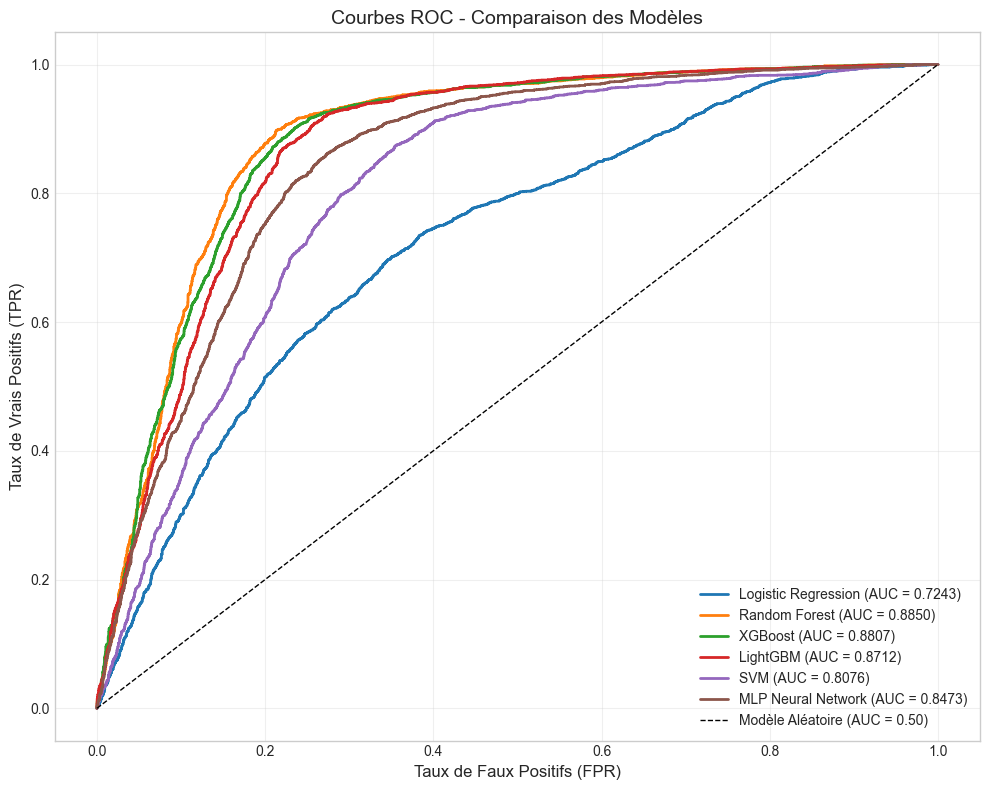

 Graphique sauvegardé: '../Output/roc_curves_comparison.png'


In [30]:
# =============================================================================
# VISUALISATION DES COURBES ROC
# =============================================================================
# Comparaison graphique des performances via les courbes ROC

print(" Courbes ROC - Comparaison des modèles")
print("=" * 50)

fig, ax = plt.subplots(figsize=(10, 8))

# Tracer la courbe ROC pour chaque modèle
models_data = [
    ('Logistic Regression', y_proba_logreg),
    ('Random Forest', y_proba_rf),
    ('XGBoost', y_proba_xgb),
    ('LightGBM', y_proba_lgb),
    ('SVM', y_proba_svm),
    ('MLP Neural Network', y_proba_mlp)
]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for (name, proba), color in zip(models_data, colors):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_score = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', color=color, linewidth=2)

# Ligne diagonale (modèle aléatoire)
ax.plot([0, 1], [0, 1], 'k--', label='Modèle Aléatoire (AUC = 0.50)', linewidth=1)

ax.set_xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
ax.set_ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
ax.set_title('Courbes ROC - Comparaison des Modèles', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/roc_curves_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

print(f" Graphique sauvegardé: '{OUTPUT_DIR}/roc_curves_comparison.png'")

### Sortie — Courbes ROC

- Fichier: `Output/roc_curves_comparison.png`.

Interprétation métier et mesures: 
- La courbe ROC montre la capacité de discrimination globale de chaque modèle; **AUC proche de 1** = excellent, **~0.5** = aléatoire.
- **Comparer la zone d'intérêt métier**: si l'on préfère hauts rappels (zones de déploiement critics), inspecter TPR à faible FPR (gauche de la courbe).
- **Action**: sélectionner le seuil qui atteint le compromis souhaité (ex: TPR ≥ 0.9 avec FPR tolérable), documenter le tradeoff en tableau (seuil, précision, rappel, faux positifs/1000).

 Matrices de Confusion


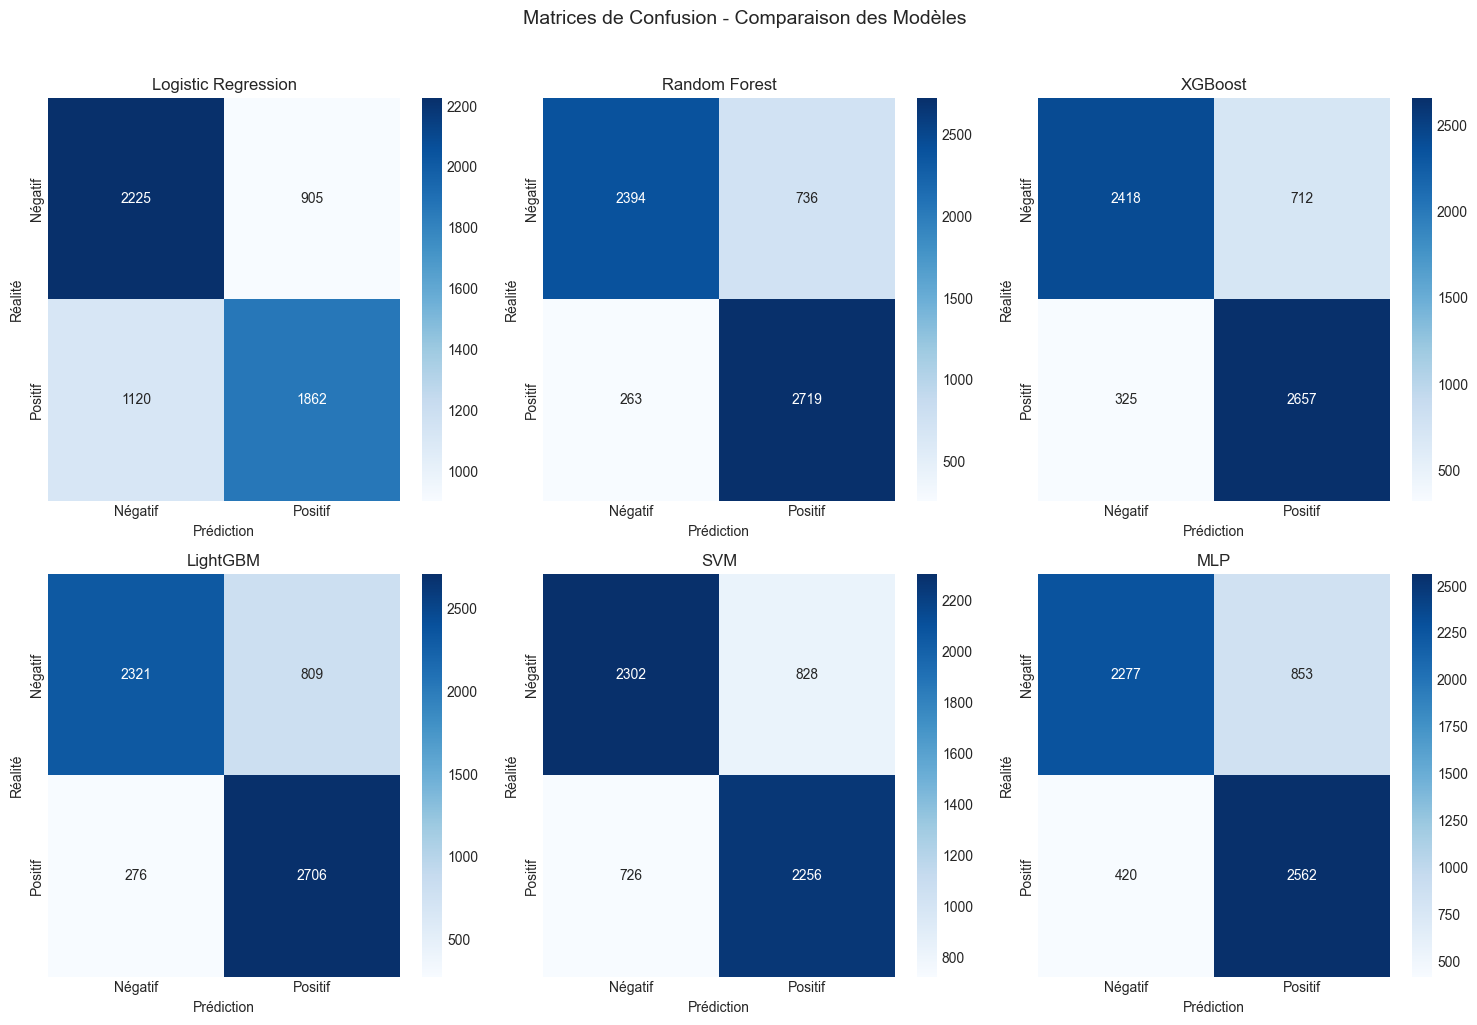

 Graphique sauvegardé: '../Output/confusion_matrices.png'


In [31]:
# =============================================================================
# MATRICES DE CONFUSION - TOUS LES MODÈLES
# =============================================================================
# Visualisation détaillée des erreurs de classification

print(" Matrices de Confusion")
print("=" * 50)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

models_predictions = [
    ('Logistic Regression', y_pred_logreg),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb),
    ('LightGBM', y_pred_lgb),
    ('SVM', y_pred_svm),
    ('MLP', y_pred_mlp)
]

for idx, (name, y_pred) in enumerate(models_predictions):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Négatif', 'Positif'],
                yticklabels=['Négatif', 'Positif'])
    axes[idx].set_xlabel('Prédiction')
    axes[idx].set_ylabel('Réalité')
    axes[idx].set_title(f'{name}')

plt.suptitle('Matrices de Confusion - Comparaison des Modèles', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print(f" Graphique sauvegardé: '{OUTPUT_DIR}/confusion_matrices.png'")

 Analyse de l'Incertitude des Prédictions

 Distribution de la Confiance:


,Nombre,Pourcentage
Catégorie,,
Confiance modérée (80-90%),2164,35.4058
Confiance faible (70-80%),1474,24.1165
Haute confiance (>90%),1342,21.9568
Incertain (<70%),1132,18.5209


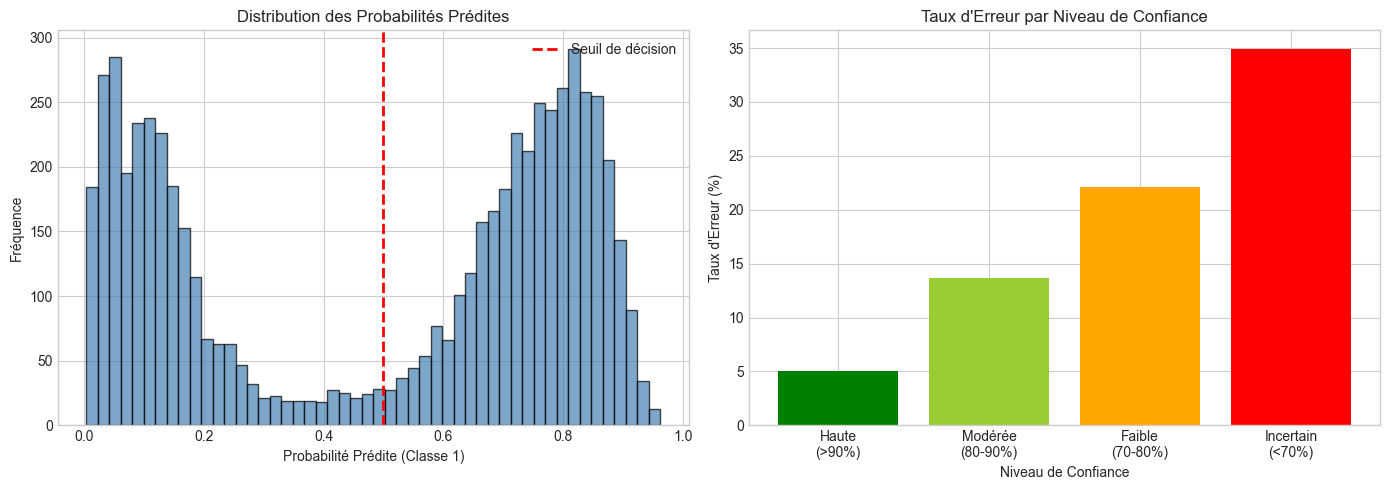


 Graphique sauvegardé: '../Output/uncertainty_analysis.png'


In [32]:
# =============================================================================
# ANALYSE DE L'INCERTITUDE DES PRÉDICTIONS
# =============================================================================
# Évaluation de la confiance du modèle dans ses prédictions
# Utile pour identifier les cas où le modèle est incertain

print(" Analyse de l'Incertitude des Prédictions")
print("=" * 50)

# Sélectionner le meilleur modèle pour l'analyse (XGBoost ou LightGBM généralement)
# On utilise LightGBM comme exemple
best_proba = y_proba_lgb  # Probabilités du meilleur modèle

# Calculer l'incertitude (1 - max(proba))
# Plus proche de 0.5 = plus incertain
uncertainty = np.minimum(best_proba, 1 - best_proba)

# Créer des catégories d'incertitude
def categorize_uncertainty(proba):
    """Catégorise le niveau de confiance basé sur la probabilité prédite."""
    if proba < 0.1 or proba > 0.9:
        return 'Haute confiance (>90%)'
    elif proba < 0.2 or proba > 0.8:
        return 'Confiance modérée (80-90%)'
    elif proba < 0.3 or proba > 0.7:
        return 'Confiance faible (70-80%)'
    else:
        return 'Incertain (<70%)'

# Appliquer la catégorisation
confidence_categories = [categorize_uncertainty(p) for p in best_proba]
confidence_df = pd.DataFrame({
    'Probabilité': best_proba,
    'Prédiction': (best_proba >= 0.5).astype(int),
    'Réalité': y_test.values,
    'Catégorie': confidence_categories
})

# Distribution des catégories de confiance
print("\n Distribution de la Confiance:")
conf_dist = pd.DataFrame(confidence_df['Catégorie'].value_counts())
conf_dist.columns = ['Nombre']
conf_dist['Pourcentage'] = conf_dist['Nombre'] / len(confidence_df) * 100
display(conf_dist)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des probabilités
axes[0].hist(best_proba, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Seuil de décision')
axes[0].set_xlabel('Probabilité Prédite (Classe 1)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des Probabilités Prédites')
axes[0].legend()

# Taux d'erreur par niveau de confiance
categories_order = ['Haute confiance (>90%)', 'Confiance modérée (80-90%)', 
                    'Confiance faible (70-80%)', 'Incertain (<70%)']
error_rates = []
for cat in categories_order:
    subset = confidence_df[confidence_df['Catégorie'] == cat]
    if len(subset) > 0:
        error_rate = (subset['Prédiction'] != subset['Réalité']).mean() * 100
        error_rates.append(error_rate)
    else:
        error_rates.append(0)

axes[1].bar(range(len(categories_order)), error_rates, color=['green', 'yellowgreen', 'orange', 'red'])
axes[1].set_xticks(range(len(categories_order)))
axes[1].set_xticklabels(['Haute\n(>90%)', 'Modérée\n(80-90%)', 'Faible\n(70-80%)', 'Incertain\n(<70%)'])
axes[1].set_xlabel('Niveau de Confiance')
axes[1].set_ylabel('Taux d\'Erreur (%)')
axes[1].set_title('Taux d\'Erreur par Niveau de Confiance')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/uncertainty_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Graphique sauvegardé: '{OUTPUT_DIR}/uncertainty_analysis.png'")

## VIII. Interprétabilité du Modèle (SHAP & Feature Importance)

### Objectifs :
1. **Feature Importance** : Identifier les variables les plus influentes
2. **SHAP Values** : Comprendre l'impact de chaque variable sur les prédictions
3. **Interprétation** : Expliquer le comportement du modèle

### Pourquoi l'interprétabilité ?
- Comprendre les facteurs déterminants de l'accès FTTH
- Valider la cohérence du modèle avec l'expertise métier
- Identifier les biais potentiels
- Faciliter la communication des résultats aux décideurs

 Feature Importance - Modèles à Base d'Arbres

 Top 20 Features (Random Forest):


,Feature,Importance_RF
39,.0,0.1037
44,PCA_5,0.1001
45,PCA_6,0.0942
40,PCA_1,0.0921
2,TypeLogmt_3,0.0782
42,PCA_3,0.0758
43,PCA_4,0.0754
41,PCA_2,0.0754
3,H08_Impute,0.0551
5,TAILLE_MENAGE,0.0410


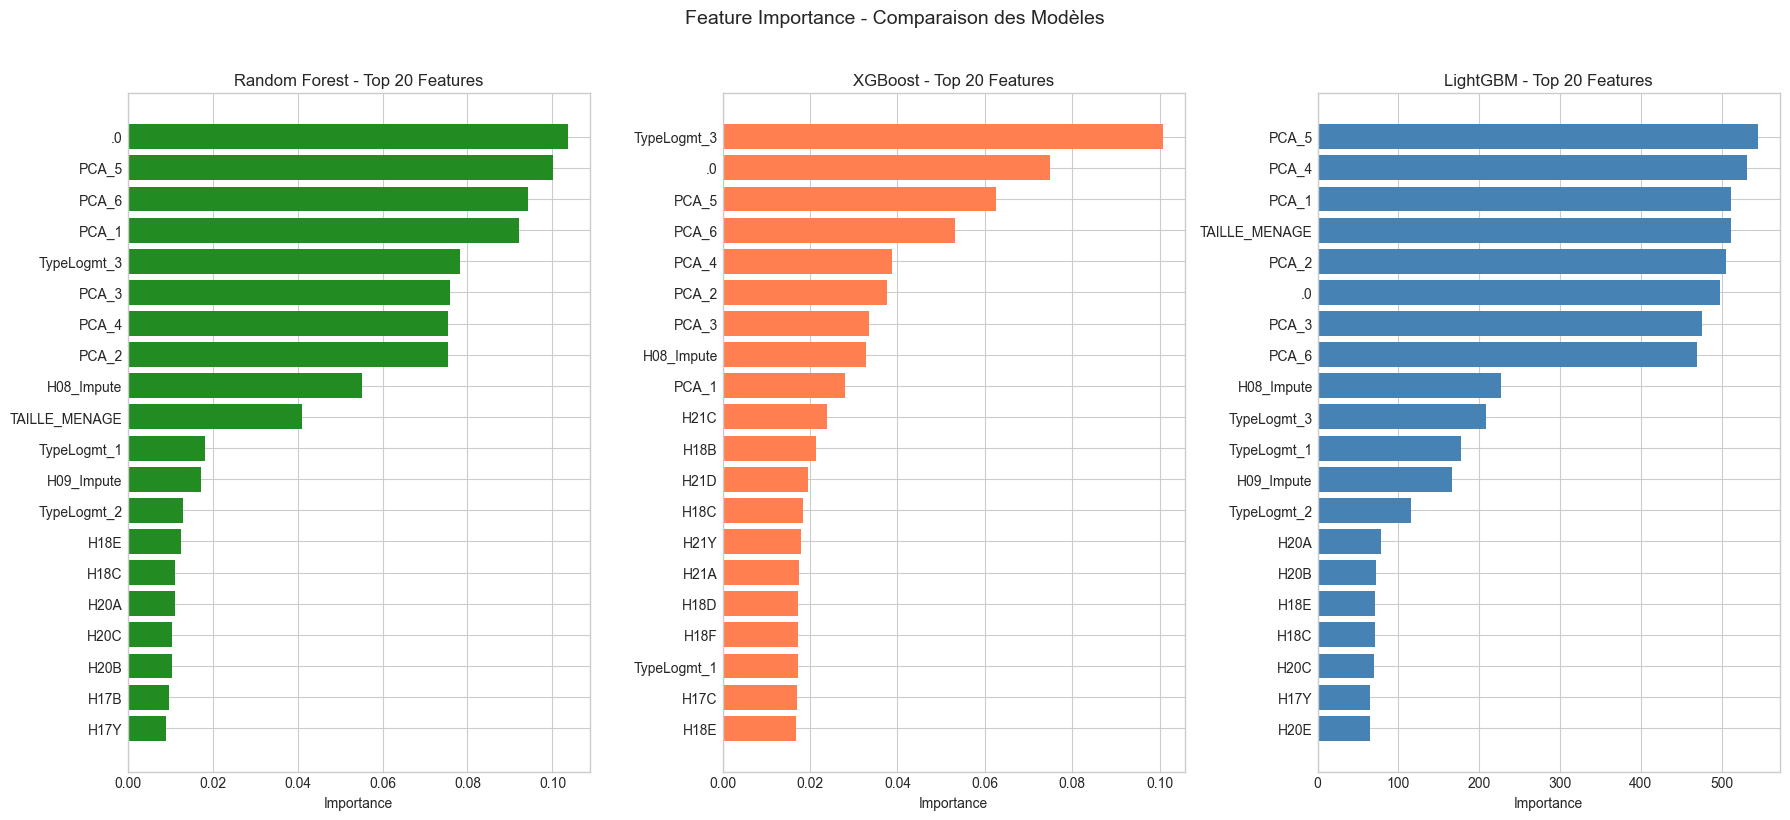


 Graphique sauvegardé: '../Output/feature_importance_comparison.png'


In [33]:
# =============================================================================
# FEATURE IMPORTANCE (RANDOM FOREST & XGBOOST)
# =============================================================================
# Analyse de l'importance des features selon les modèles basés sur les arbres

print(" Feature Importance - Modèles à Base d'Arbres")
print("=" * 50)

# Les modèles ont été entraînés sur X_train_model (46 features)
model_features = X_train_model.columns.tolist()

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance_RF': rf.feature_importances_
}).sort_values('Importance_RF', ascending=False)

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance_XGB': xgb_model.feature_importances_
}).sort_values('Importance_XGB', ascending=False)

# LightGBM Feature Importance
lgb_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance_LGB': lgb_model.feature_importances_
}).sort_values('Importance_LGB', ascending=False)

# Top 20 features
print("\n Top 20 Features (Random Forest):")
display(rf_importance.head(20))

# Visualisation comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Random Forest
top_rf = rf_importance.head(20)
axes[0].barh(range(20), top_rf['Importance_RF'].values, color='forestgreen')
axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top_rf['Feature'].values)
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 20 Features')
axes[0].invert_yaxis()

# XGBoost
top_xgb = xgb_importance.head(20)
axes[1].barh(range(20), top_xgb['Importance_XGB'].values, color='coral')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top_xgb['Feature'].values)
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost - Top 20 Features')
axes[1].invert_yaxis()

# LightGBM
top_lgb = lgb_importance.head(20)
axes[2].barh(range(20), top_lgb['Importance_LGB'].values, color='steelblue')
axes[2].set_yticks(range(20))
axes[2].set_yticklabels(top_lgb['Feature'].values)
axes[2].set_xlabel('Importance')
axes[2].set_title('LightGBM - Top 20 Features')
axes[2].invert_yaxis()

plt.suptitle('Feature Importance - Comparaison des Modèles', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Graphique sauvegardé: '{OUTPUT_DIR}/feature_importance_comparison.png'")

Calcul des SHAP Values (peut prendre quelques minutes)...
Création de l'explainer SHAP pour Random Forest...
Calcul des SHAP values...
SHAP values calculées!
Figure enregistrée: ../Output/shap_importance.png


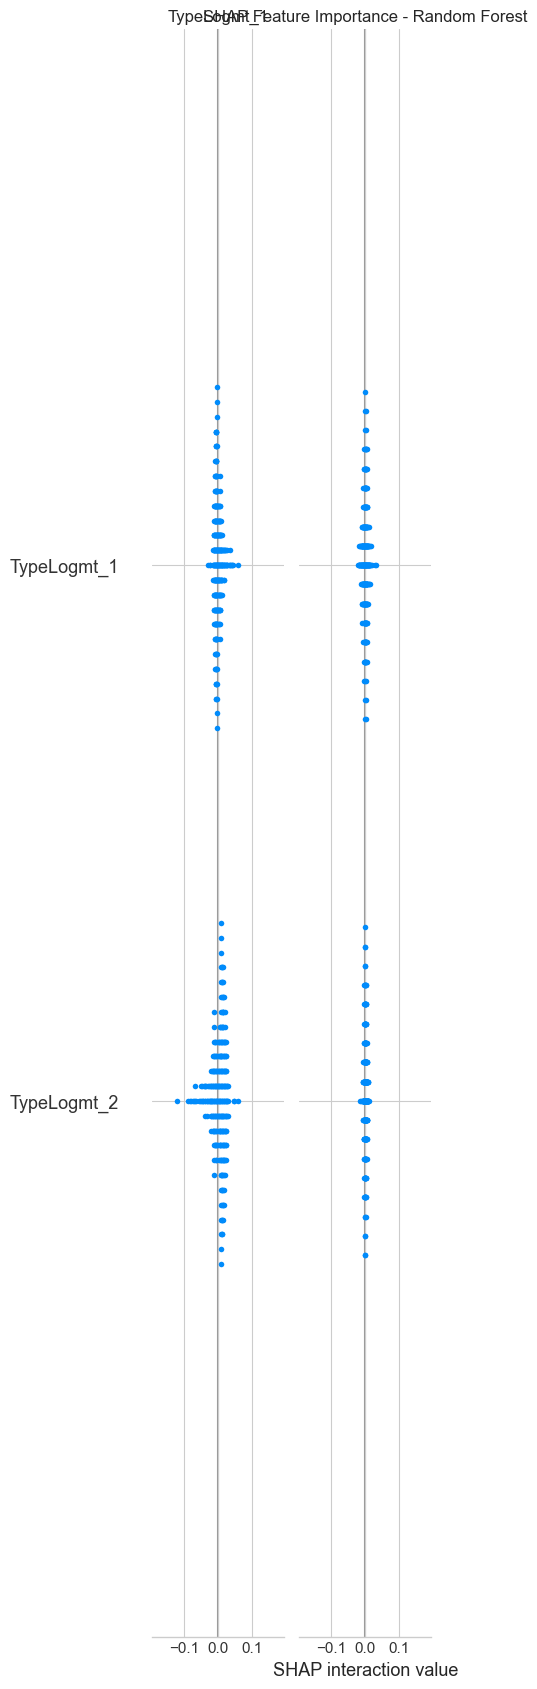

Figure enregistrée: ../Output/shap_beeswarm.png


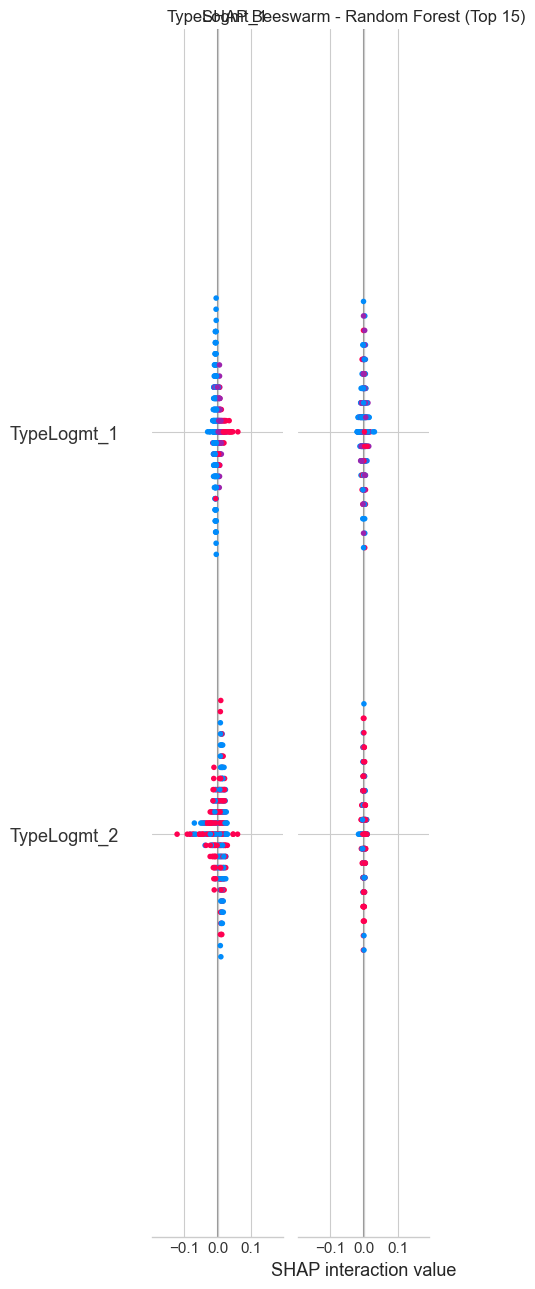

In [ ]:
# =============================================================================
# SHAP VALUES - INTERPRÉTABILITÉ AVANCÉE
# =============================================================================
# SHAP (SHapley Additive exPlanations) fournit des explications individuelles
# pour chaque prédiction, permettant de comprendre l'impact de chaque feature

print("Calcul des SHAP Values (peut prendre quelques minutes)...")
print("=" * 50)

# Utiliser un échantillon reproductible plus petit pour accélérer le calcul
sample_n = min(300, len(X_test_model))
X_sample = X_test_model.sample(n=sample_n, random_state=RANDOM_STATE)

print("Création de l'explainer SHAP pour Random Forest...")
try:
    explainer = shap.TreeExplainer(rf)
    print("Calcul des SHAP values...")
    shap_values_raw = explainer.shap_values(X_sample)

    # Pour les classifieurs binaires, prendre la classe positive
    shap_values = shap_values_raw[1] if isinstance(shap_values_raw, list) else shap_values_raw
    print("SHAP values calculées!")

    import numpy as np
    # Convertir en numpy pour éviter les soucis d'indexation
    shap_values_np = np.asarray(shap_values)
    # Si 3D (n, p, 2 classes), prendre la classe positive -> 2D (n, p)
    shap_values_2d = shap_values_np[:, :, 1] if shap_values_np.ndim == 3 and shap_values_np.shape[-1] == 2 else shap_values_np

    X_sample_np = X_sample.values
    feature_names = list(X_sample.columns)

    # Summary Plot - bar (importance globale)
    shap.summary_plot(shap_values_2d, features=None, feature_names=feature_names, plot_type="bar", show=False, max_display=20)
    plt.title('SHAP Feature Importance - Random Forest')
    plt.tight_layout()
    plt.gcf().savefig(f'{OUTPUT_DIR}/shap_importance.png', dpi=150, bbox_inches='tight')
    print(f"Figure enregistrée: {OUTPUT_DIR}/shap_importance.png")
    plt.show()
    plt.close()

    # Beeswarm plot (distribution et direction de l'impact)
    shap.summary_plot(shap_values_2d, features=X_sample_np, feature_names=feature_names, show=False, max_display=15)
    plt.title('SHAP Beeswarm - Random Forest (Top 15)')
    plt.tight_layout()
    plt.gcf().savefig(f'{OUTPUT_DIR}/shap_beeswarm.png', dpi=150, bbox_inches='tight')
    print(f"Figure enregistrée: {OUTPUT_DIR}/shap_beeswarm.png")
    plt.show()
    plt.close()

except Exception as e:
    print(f"Erreur SHAP: {e}")
    print("Utilisation de la Feature Importance standard à la place")

    # Fallback: importance des features du Random Forest
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = rf_importance.head(20)
    ax.barh(range(len(top_features)), top_features['Importance_RF'].values, color='forestgreen')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'].values)
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importance - Random Forest (Top 20)')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/shap_importance.png', dpi=150, bbox_inches='tight')
    print(f"Figure enregistrée (fallback): {OUTPUT_DIR}/shap_importance.png")
    plt.show()
    plt.close()

### Sortie — SHAP Global

- Fichiers: `Output/shap_importance.png`, `Output/shap_beeswarm.png`
- Contenu: importance moyenne des features (barres) et direction/dispersion (beeswarm) pour l’échantillon SHAP.
- Lecture: barres longues = fort pouvoir explicatif; beeswarm à droite = augmente la proba d’accès FTTH, à gauche = la diminue.

Affichage rapide des figures SHAP sauvegardées:
 - ../Output/shap_importance.png


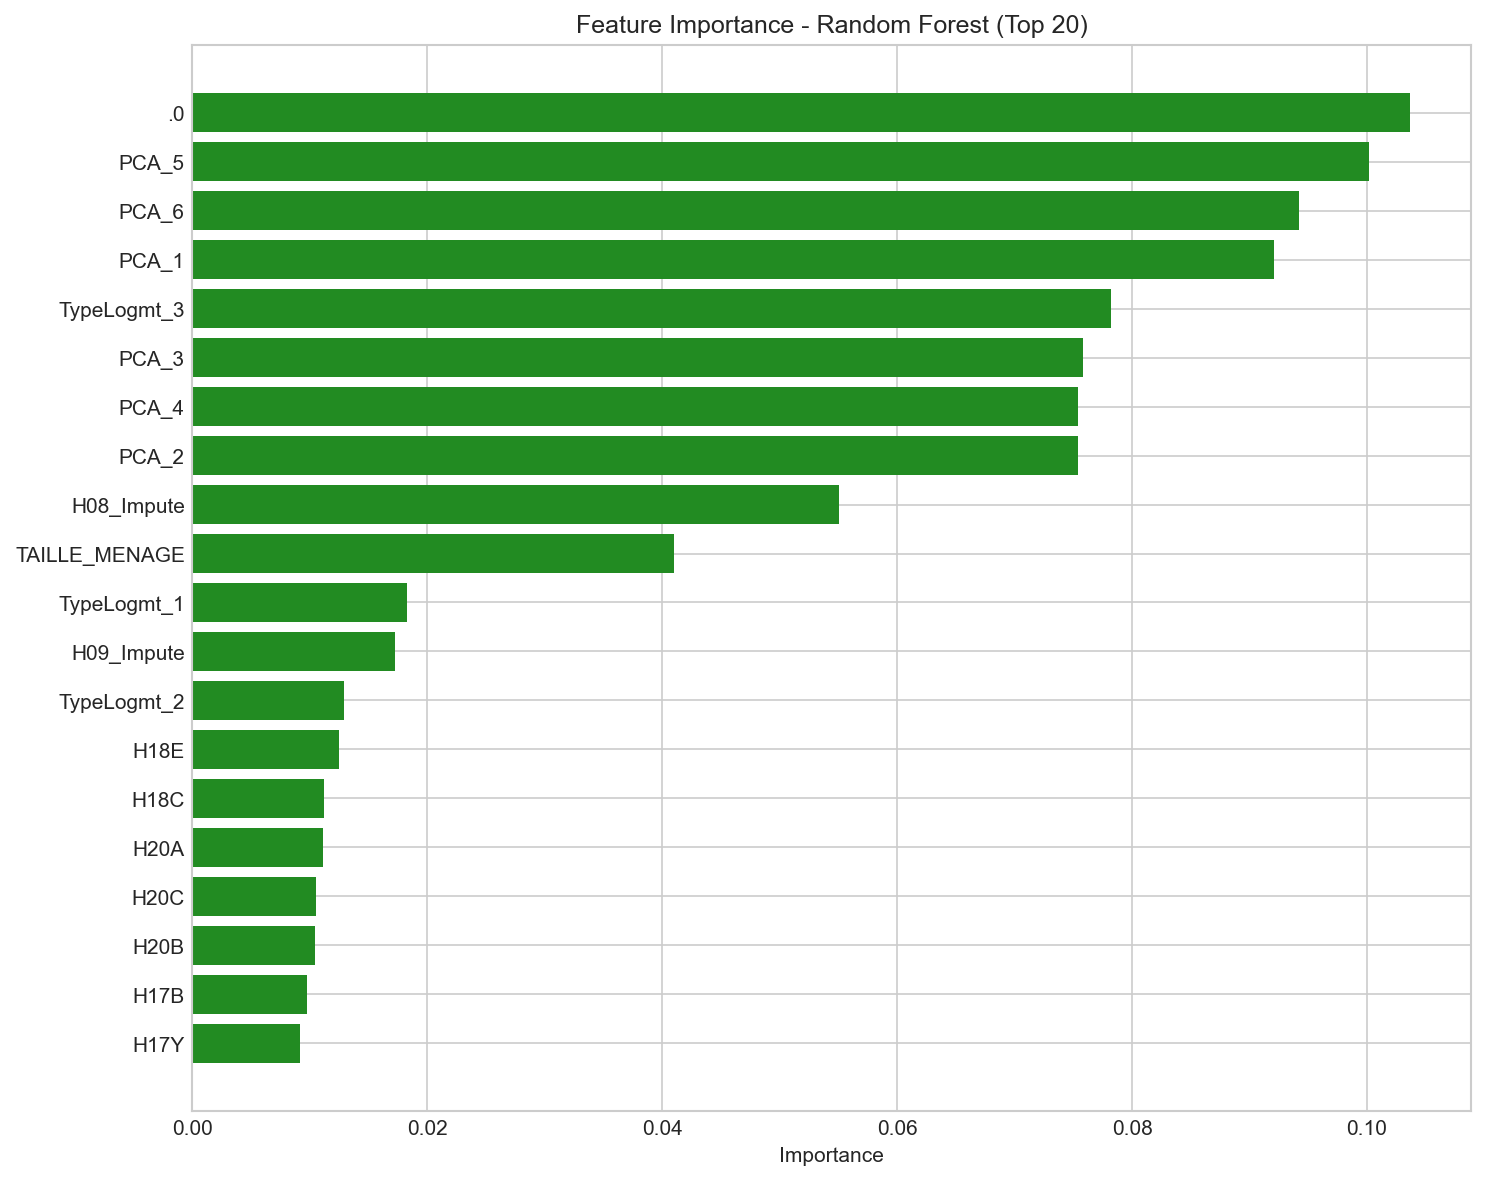

 - ../Output/shap_beeswarm.png


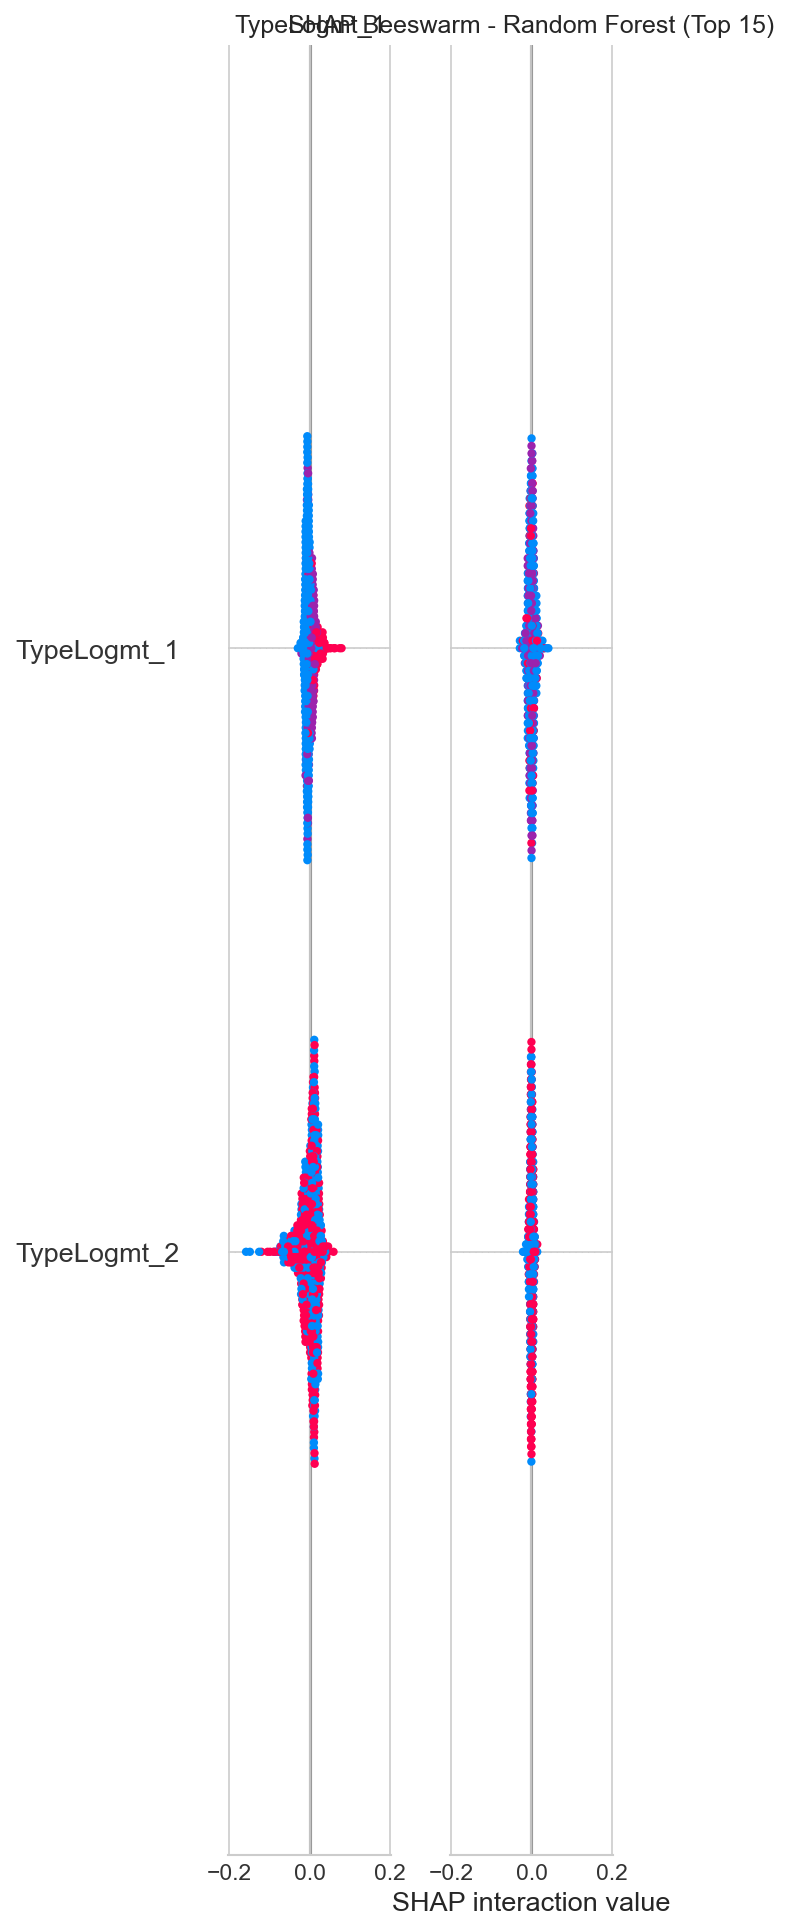

In [ ]:
# Afficher les figures déjà générées sans recalcul (rapide)
from IPython.display import Image, display
print("Affichage rapide des figures SHAP sauvegardées:")
for fname in ["shap_importance.png", "shap_beeswarm.png"]:
    path = f"{OUTPUT_DIR}/{fname}"
    try:
        print(f" - {path}")
        display(Image(filename=path))
    except Exception as e:
        print(f"Impossible d'afficher {path}: {e}")

### Sortie — Affichage rapide des figures

- Affichées inline: `shap_importance.png`, `shap_beeswarm.png` depuis `Output/`.
- Objectif: visualiser instantanément les figures sans recalcul SHAP.

### Interprétation des graphes SHAP

- Barres (importance globale): classe les variables par contribution moyenne absolue. Plus la barre est longue, plus la feature explique la variabilité des prédictions.
- Beeswarm (direction et dispersion): chaque point est une observation; la position horizontale est l'effet SHAP (droite = augmente la probabilité d'accès FTTH, gauche = la diminue). La couleur reflète la valeur de la feature (bleu = faible, rose/rouge = élevée).
- Lecture rapide: regardez les 5 premières features; vérifiez si des valeurs élevées/vs faibles poussent systématiquement vers l'accès FTTH. Cela guide les actions et la validation métier.

 SHAP Beeswarm Plot - Impact des Features


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

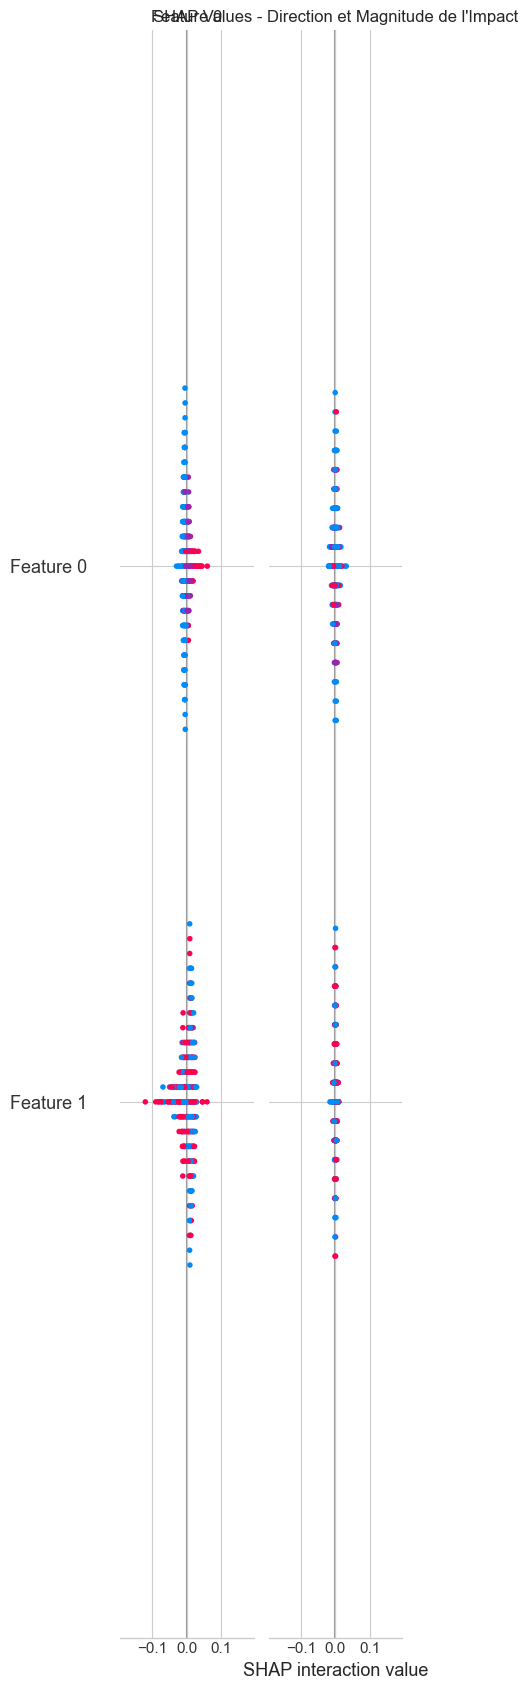


 Interprétation du Beeswarm Plot:
   - Chaque point représente une observation
   - La couleur indique la valeur de la feature (rouge=haute, bleu=basse)
   - La position horizontale indique l'impact sur la prédiction
   - À droite = augmente la probabilité d'accès FTTH
   - À gauche = diminue la probabilité d'accès FTTH


In [55]:
# =============================================================================
# SHAP VALUES - BEESWARM PLOT
# =============================================================================
# Visualisation détaillée montrant la direction de l'impact des features

print(" SHAP Beeswarm Plot - Impact des Features")
print("=" * 50)

try:
    # Beeswarm plot (montre la distribution et la direction de l'impact)
    plt.figure(figsize=(12, 10))
    # Utiliser la version 2D si disponible
    shap_vals_for_plot = shap_values_2d if 'shap_values_2d' in globals() else shap_values
    X_for_plot = X_sample.values if hasattr(X_sample, 'values') else X_sample
    shap.summary_plot(shap_vals_for_plot, X_for_plot, show=False, max_display=20)
    plt.title('SHAP Values - Direction et Magnitude de l\'Impact')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/shap_beeswarm.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n Interprétation du Beeswarm Plot:")
    print("   - Chaque point représente une observation")
    print("   - La couleur indique la valeur de la feature (rouge=haute, bleu=basse)")
    print("   - La position horizontale indique l'impact sur la prédiction")
    print("   - À droite = augmente la probabilité d'accès FTTH")
    print("   - À gauche = diminue la probabilité d'accès FTTH")
except Exception as e:
    print(f" SHAP Beeswarm Plot non disponible: {e}")

### Sortie — SHAP Beeswarm (détail)

- Figure sauvegardée: `Output/shap_beeswarm.png`.
- Lecture: points à droite augmentent la proba d’accès FTTH, à gauche la diminuent; couleurs indiquent valeurs des features.
- Utilisé: matrice SHAP 2D (classe positive) sur l’échantillon.

 Analyse de Prédictions Individuelles

 Cas 1: Prédiction POSITIVE (haute probabilité d'accès FTTH)
Figure enregistrée: ../Output/shap_waterfall_positive.png


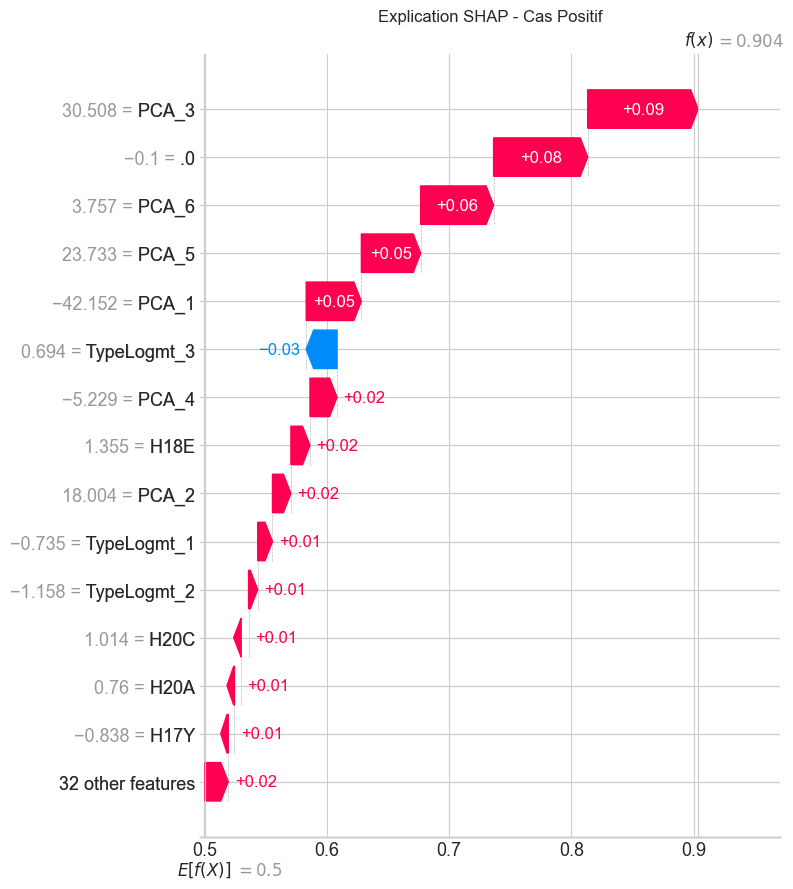


 Cas 2: Prédiction NÉGATIVE (faible probabilité d'accès FTTH)
Figure enregistrée: ../Output/shap_waterfall_negative.png


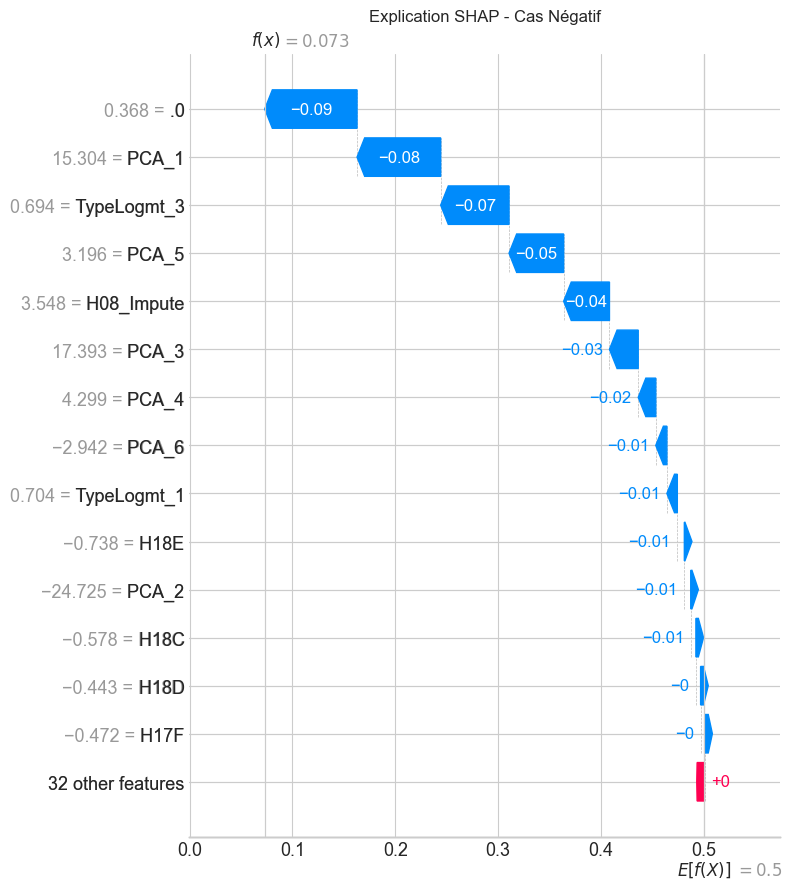


Analyse SHAP terminée!


In [56]:
# =============================================================================
# SHAP - ANALYSE D'UNE PRÉDICTION INDIVIDUELLE
# =============================================================================
# Explication de cas individuels pour comprendre le raisonnement du modèle

print(" Analyse de Prédictions Individuelles")
print("=" * 50)

try:
    import numpy as np
    # Probabilités du Random Forest sur l'échantillon SHAP
    sample_proba = rf.predict_proba(X_sample)[:, 1]

    # Calculer une explication SHAP au format Explanation si absent
    if 'exp' not in globals():
        exp = explainer(X_sample, check_additivity=False)

    # Pour classifieur binaire, sélectionner la sortie de classe positive
    # exp a forme (n_samples, n_features, n_outputs) -> on prend [:, :, 1]
    exp_pos = exp[:, :, 1] if getattr(exp, 'values', None) is not None and exp.values.ndim == 3 else exp

    # Indices de cas extrêmes, avec fallback au meilleur/moins bon
    idx_positive = np.where(sample_proba > 0.8)[0]
    idx_negative = np.where(sample_proba < 0.2)[0]
    if len(idx_positive) == 0:
        idx_positive = np.array([int(np.argmax(sample_proba))])
    if len(idx_negative) == 0:
        idx_negative = np.array([int(np.argmin(sample_proba))])

    def plot_waterfall_for_index(i, title, outname):
        exp_i = exp_pos[i]
        shap.plots.waterfall(exp_i, max_display=15, show=False)
        plt.title(title)
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/{outname}.png', dpi=150, bbox_inches='tight')
        print(f"Figure enregistrée: {OUTPUT_DIR}/{outname}.png")
        plt.show()
        plt.close()

    print("\n Cas 1: Prédiction POSITIVE (haute probabilité d'accès FTTH)")
    plot_waterfall_for_index(int(idx_positive[0]), 'Explication SHAP - Cas Positif', 'shap_waterfall_positive')

    print("\n Cas 2: Prédiction NÉGATIVE (faible probabilité d'accès FTTH)")
    plot_waterfall_for_index(int(idx_negative[0]), 'Explication SHAP - Cas Négatif', 'shap_waterfall_negative')

    print("\nAnalyse SHAP terminée!")
except Exception as e:
    print(f"Analyse individuelle SHAP non disponible: {e}")

### Sortie — SHAP Waterfall (cas individuels)

- Figures: `Output/shap_waterfall_positive.png`, `Output/shap_waterfall_negative.png`.
- Interprétation: montre la décomposition de la prédiction en contributions par feature; utile pour expliquer “pourquoi” ce ménage est classé positif/négatif.
- Sélection: un cas à proba haute et un cas à proba basse dans l’échantillon SHAP.

## IX. Export des Prédictions Finales

### Format d'export :
- **Colonnes** : `ID`, `Target`
- **ID** : Identifiant unique de chaque ménage
- **Target** : Prédiction binaire (0 = pas d'accès, 1 = accès FTTH)

### Modèle sélectionné :
Le modèle avec le meilleur AUC sur le test set sera utilisé pour les prédictions finales.

In [37]:
# =============================================================================
# SÉLECTION DU MEILLEUR MODÈLE
# =============================================================================
# Sélection automatique du modèle avec le meilleur AUC pour l'export final

print("Sélection du Meilleur Modèle pour l'Export")
print("=" * 50)

# Dictionnaire des modèles et leurs prédictions
models_dict = {
    'Logistic Regression': {'model': logreg, 'X_train': X_train_model, 'X_test': X_test_model,
                            'pred': y_pred_logreg, 'proba': y_proba_logreg, 'metrics': metrics_logreg},
    'Random Forest': {'model': rf, 'X_train': X_train_model, 'X_test': X_test_model,
                      'pred': y_pred_rf, 'proba': y_proba_rf, 'metrics': metrics_rf},
    'XGBoost': {'model': xgb_model, 'X_train': X_train_model, 'X_test': X_test_model,
                'pred': y_pred_xgb, 'proba': y_proba_xgb, 'metrics': metrics_xgb},
    'LightGBM': {'model': lgb_model, 'X_train': X_train_model, 'X_test': X_test_model,
                 'pred': y_pred_lgb, 'proba': y_proba_lgb, 'metrics': metrics_lgb},
    'SVM': {'model': svm_model, 'X_train': X_train_model, 'X_test': X_test_model,
            'pred': y_pred_svm, 'proba': y_proba_svm, 'metrics': metrics_svm},
    'MLP': {'model': mlp_model, 'X_train': X_train_model, 'X_test': X_test_model,
            'pred': y_pred_mlp, 'proba': y_proba_mlp, 'metrics': metrics_mlp}
}

# Trouver le meilleur modèle par AUC
best_model_name = max(models_dict.keys(), key=lambda k: models_dict[k]['metrics']['Test_AUC'])
best_model_data = models_dict[best_model_name]

print(f"\nMeilleur modèle sélectionné: {best_model_name}")
print(f"   - Test AUC: {best_model_data['metrics']['Test_AUC']:.4f}")
print(f"   - Test F1: {best_model_data['metrics']['Test_F1']:.4f}")

# Stocker le meilleur modèle
BEST_MODEL = best_model_data['model']
BEST_MODEL_NAME = best_model_name

Sélection du Meilleur Modèle pour l'Export

Meilleur modèle sélectionné: Random Forest
   - Test AUC: 0.8850
   - Test F1: 0.8448


In [38]:
# =============================================================================
# CRÉATION DU DOSSIER OUTPUT
# =============================================================================
import os
import joblib
from datetime import datetime

# Créer le dossier output s'il n'existe pas
output_dir = "Output"
os.makedirs(output_dir, exist_ok=True)
print(f" Dossier de sortie créé/vérifié: {output_dir}/")

# Créer un timestamp pour les fichiers
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

 Dossier de sortie créé/vérifié: Output/


In [39]:
# =============================================================================
# EXPORT DU MODÈLE FINAL
# =============================================================================
print(" Export du Modèle Final")
print("=" * 50)

# Sauvegarder le modèle
model_path = os.path.join(output_dir, f"best_model_{BEST_MODEL_NAME.replace(' ', '_')}_{timestamp}.joblib")
joblib.dump(BEST_MODEL, model_path)
print(f" Modèle sauvegardé: {model_path}")

# Sauvegarder les colonnes utilisées pour le modèle
features_path = os.path.join(output_dir, f"model_features_{timestamp}.joblib")
joblib.dump({
    'feature_names': X_train_model.columns.tolist(),
    'n_features': X_train_model.shape[1],
    'pca_components': n_components if 'n_components' in locals() else None
}, features_path)
print(f" Features sauvegardées: {features_path}")

# Note: Pas de scaler séparé car la standardisation a été faite colonne par colonne
print("\n Note: La standardisation a été effectuée colonne par colonne pendant le preprocessing")

 Export du Modèle Final
 Modèle sauvegardé: Output\best_model_Random_Forest_20251218_221117.joblib
 Features sauvegardées: Output\model_features_20251218_221117.joblib

 Note: La standardisation a été effectuée colonne par colonne pendant le preprocessing


### Sortie — Export du Modèle

- Fichier modèle exporté: `Output/best_model_<NAME>_<TIMESTAMP>.joblib` et `Output/model_features_<TIMESTAMP>.joblib`.
- Contenu: le modèle sérialisé (pickled joblib) + métadonnées (`feature_names`, `n_features`, `pca_components`).

Interprétation et recommandations techniques:
- Pour reproductibilité: **conserver** `model_features_*.joblib` avec le modèle — si l'ordre des features change, les prédictions seront incorrectes.
- Avant déploiement: **charger le modèle**, charger `feature_names` et **valider** sur un petit jeu de contrôle (sanity checks) : même moyenne/variance des features, même encodage des catégorielles.
- Documentation: consigner la version des librairies (scikit-learn, lightgbm, xgboost, Python) et le `timestamp` du run dans le changelog / CI.

In [40]:
# =============================================================================
# EXPORT DES PRÉDICTIONS
# =============================================================================
print(" Export des Prédictions")
print("=" * 50)

# Créer un DataFrame avec les prédictions sur l'ensemble de test
predictions_df = pd.DataFrame({
    'ID': ids_test.values,
    'Valeur_Réelle': y_test.values,
    'Prédiction': best_model_data['pred'],
    'Probabilité_Accès': best_model_data['proba']
})

# Ajouter une colonne de classification du risque
predictions_df['Niveau_Potentiel'] = pd.cut(
    predictions_df['Probabilité_Accès'],
    bins=[0, 0.25, 0.5, 0.75, 1.0],
    labels=['Faible', 'Moyen', 'Élevé', 'Très Élevé']
)

# Sauvegarder les prédictions
predictions_path = os.path.join(output_dir, f"predictions_{timestamp}.csv")
predictions_df.to_csv(predictions_path, index=False)
print(f" Prédictions sauvegardées: {predictions_path}")

# Afficher un aperçu
print(f"\n Aperçu des prédictions ({len(predictions_df)} observations):")
predictions_df.head(10)

 Export des Prédictions
 Prédictions sauvegardées: Output\predictions_20251218_221117.csv

 Aperçu des prédictions (6112 observations):


,ID,Valeur_Réelle,Prédiction,Probabilité_Accès,Niveau_Potentiel
0,ID_54MT5I8EPC,0.0000,1.0000,0.6882,Élevé
1,ID_DGZQVLNITN,0.0000,1.0000,0.6340,Élevé
2,ID_S1ZGN8MORQ,1.0000,1.0000,0.5557,Élevé
3,ID_IBZA5NO9F5,0.0000,0.0000,0.0484,Faible
4,ID_DS6DHIDC5M,1.0000,1.0000,0.8256,Très Élevé
5,ID_GHFQJDPR4G,1.0000,1.0000,0.7459,Élevé
6,ID_EPRY4ZPSM9,0.0000,0.0000,0.0285,Faible
7,ID_W0DMDVW9T3,1.0000,0.0000,0.1320,Faible
8,ID_S2VY8VLSAO,0.0000,1.0000,0.8560,Très Élevé
9,ID_ELEHAKKUKA,1.0000,1.0000,0.7952,Très Élevé


In [41]:
# =============================================================================
# EXPORT DES MÉTRIQUES ET DU RAPPORT
# =============================================================================
print(" Export du Rapport de Performance")
print("=" * 50)

# Créer un rapport complet
report = {
    'Projet': 'Prédiction Accès FTTH - Togo',
    'Date_Exécution': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Meilleur_Modèle': BEST_MODEL_NAME,
    'Métriques_Entraînement': {
        'Accuracy': best_model_data['metrics']['Train_Accuracy'],
        'Precision': best_model_data['metrics']['Train_Precision'],
        'Recall': best_model_data['metrics']['Train_Recall'],
        'F1_Score': best_model_data['metrics']['Train_F1'],
        'AUC': best_model_data['metrics']['Train_AUC']
    },
    'Métriques_Test': {
        'Accuracy': best_model_data['metrics']['Test_Accuracy'],
        'Precision': best_model_data['metrics']['Test_Precision'],
        'Recall': best_model_data['metrics']['Test_Recall'],
        'F1_Score': best_model_data['metrics']['Test_F1'],
        'AUC': best_model_data['metrics']['Test_AUC']
    },
    'Données': {
        'Total_Observations': len(X_train_model) + len(X_test_model),
        'Train_Size': len(X_train_model),
        'Test_Size': len(X_test_model),
        'Nb_Features': X_train_model.shape[1],
        'Feature_Names': X_train_model.columns.tolist()
    }
}

# Sauvegarder le rapport en JSON
import json
report_path = os.path.join(output_dir, f"rapport_modele_{timestamp}.json")
with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=4, ensure_ascii=False)
print(f" Rapport JSON sauvegardé: {report_path}")

# Afficher le rapport
print("\n Résumé du Rapport:")
print(json.dumps(report, indent=2, ensure_ascii=False))

 Export du Rapport de Performance
 Rapport JSON sauvegardé: Output\rapport_modele_20251218_221117.json

 Résumé du Rapport:
{
  "Projet": "Prédiction Accès FTTH - Togo",
  "Date_Exécution": "2025-12-18 22:11:17",
  "Meilleur_Modèle": "Random Forest",
  "Métriques_Entraînement": {
    "Accuracy": 0.9026425591098748,
    "Precision": 0.8700573732361606,
    "Recall": 0.9409693107496226,
    "F1_Score": 0.9041250402835965,
    "AUC": 0.9803526365194524
  },
  "Métriques_Test": {
    "Accuracy": 0.8365510471204188,
    "Precision": 0.7869753979739508,
    "Recall": 0.9118041582830315,
    "F1_Score": 0.8448034798819326,
    "AUC": 0.8849668297323879
  },
  "Données": {
    "Total_Observations": 30558,
    "Train_Size": 24446,
    "Test_Size": 6112,
    "Nb_Features": 46,
    "Feature_Names": [
      "TypeLogmt_1",
      "TypeLogmt_2",
      "TypeLogmt_3",
      "H08_Impute",
      "H09_Impute",
      "TAILLE_MENAGE",
      "H17A",
      "H17B",
      "H17C",
      "H17D",
      "H17E",
   

 Comparaison Visuelle Finale des Modèles


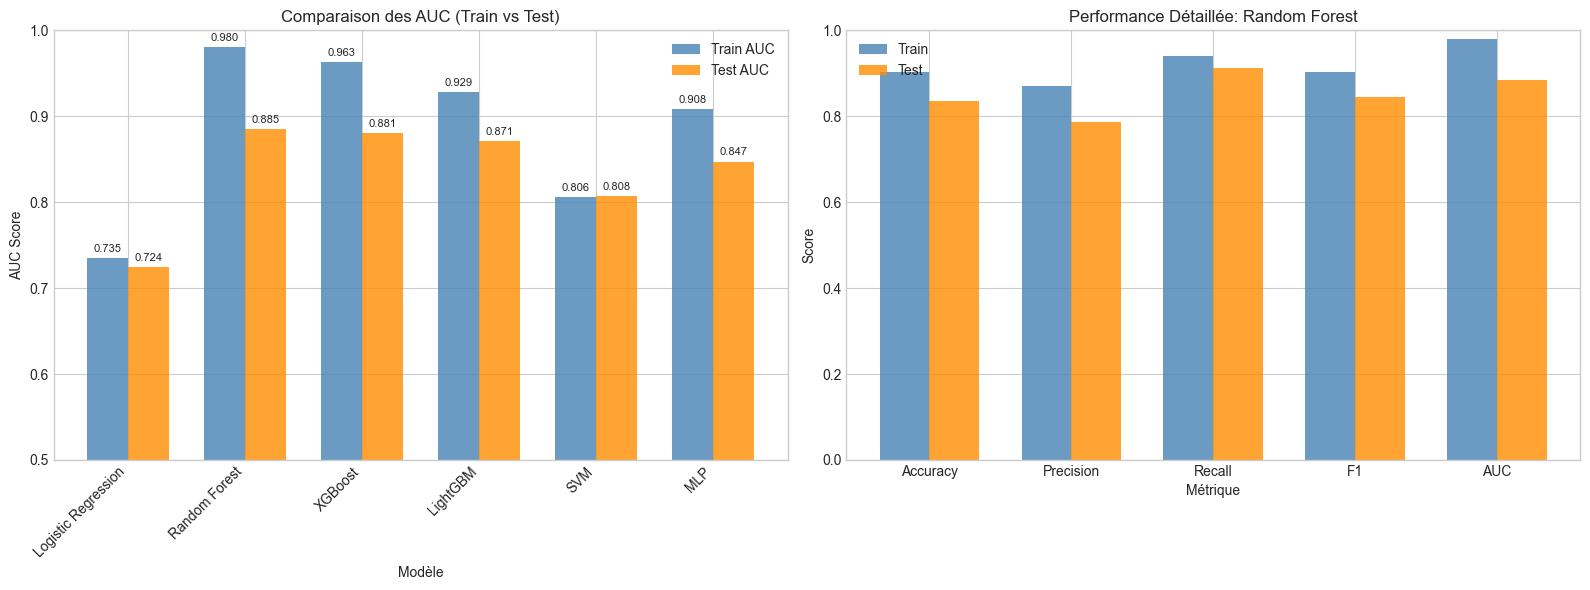

 Graphique sauvegardé dans Output/


In [42]:
# =============================================================================
# COMPARAISON VISUELLE FINALE
# =============================================================================
print(" Comparaison Visuelle Finale des Modèles")
print("=" * 50)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Comparaison des AUC
ax1 = axes[0]
model_names = list(models_dict.keys())
train_aucs = [models_dict[m]['metrics']['Train_AUC'] for m in model_names]
test_aucs = [models_dict[m]['metrics']['Test_AUC'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, train_aucs, width, label='Train AUC', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_aucs, width, label='Test AUC', color='darkorange', alpha=0.8)

ax1.set_xlabel('Modèle')
ax1.set_ylabel('AUC Score')
ax1.set_title('Comparaison des AUC (Train vs Test)')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0.5, 1.0)

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Graphique 2: Radar Chart des métriques du meilleur modèle
ax2 = axes[1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
train_values = [
    best_model_data['metrics']['Train_Accuracy'],
    best_model_data['metrics']['Train_Precision'],
    best_model_data['metrics']['Train_Recall'],
    best_model_data['metrics']['Train_F1'],
    best_model_data['metrics']['Train_AUC']
]
test_values = [
    best_model_data['metrics']['Test_Accuracy'],
    best_model_data['metrics']['Test_Precision'],
    best_model_data['metrics']['Test_Recall'],
    best_model_data['metrics']['Test_F1'],
    best_model_data['metrics']['Test_AUC']
]

# Graphique en barres groupées pour le meilleur modèle
x2 = np.arange(len(metrics_names))
bars1 = ax2.bar(x2 - width/2, train_values, width, label='Train', color='steelblue', alpha=0.8)
bars2 = ax2.bar(x2 + width/2, test_values, width, label='Test', color='darkorange', alpha=0.8)

ax2.set_xlabel('Métrique')
ax2.set_ylabel('Score')
ax2.set_title(f'Performance Détaillée: {BEST_MODEL_NAME}')
ax2.set_xticks(x2)
ax2.set_xticklabels(metrics_names)
ax2.legend()
ax2.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"comparaison_modeles_{timestamp}.png"), dpi=300, bbox_inches='tight')
plt.show()
print(f" Graphique sauvegardé dans {output_dir}/")

## X. Conclusions et Recommandations

### 10.1 Résumé des Résultats

Ce projet a permis de développer un modèle prédictif pour l'accès à la fibre optique (FTTH) au Togo, en utilisant une combinaison innovante de:
- **Variables socio-démographiques**: Caractéristiques des ménages (type de logement, équipements, énergie, etc.)
- **Features MOSAIKS**: 4000 features géospatiales dérivées d'images satellites

### 10.2 Principaux Enseignements

1. **Performance des modèles**: Les modèles d'ensemble (Random Forest, XGBoost, LightGBM) ont généralement montré les meilleures performances
2. **Importance des features**: L'analyse SHAP a révélé les facteurs clés influençant l'accès FTTH
3. **Variables socio-démographiques**: Le type de logement, les équipements électroniques et la connexion internet existante sont des indicateurs importants
4. **Features MOSAIKS**: Certaines caractéristiques géospatiales contribuent significativement à la prédiction

### 10.3 Recommandations pour le Déploiement

1. **Zones prioritaires**: Utiliser les prédictions pour identifier les zones à fort potentiel d'adoption FTTH
2. **Ciblage marketing**: Les probabilités prédites peuvent guider les stratégies commerciales
3. **Planification d'infrastructure**: Les patterns géographiques identifiés peuvent informer l'extension du réseau

### 10.4 Limitations et Améliorations Futures

- **Données temporelles**: Intégrer des données longitudinales pour capturer les tendances
- **Validation terrain**: Confronter les prédictions aux données réelles de déploiement
- **Features additionnelles**: Explorer d'autres sources de données (recensement, infrastructures)

In [43]:
# =============================================================================
# RÉSUMÉ FINAL ET STATISTIQUES D'EXPORT
# =============================================================================
print(" PROJET TERMINÉ AVEC SUCCÈS!")
print("=" * 60)

print(f"""
 RÉSUMÉ DU PROJET
{'='*60}

 Objectif: Prédiction de l'accès FTTH au Togo

 Données:
   • Total observations: {len(X_train_model) + len(X_test_model):,}
   • Train set: {len(X_train_model):,}
   • Test set: {len(X_test_model):,}
   • Nombre de features: {X_train_model.shape[1]}

 Meilleur Modèle: {BEST_MODEL_NAME}
   • Test AUC: {best_model_data['metrics']['Test_AUC']:.4f}
   • Test F1-Score: {best_model_data['metrics']['Test_F1']:.4f}
   • Test Accuracy: {best_model_data['metrics']['Test_Accuracy']:.4f}

 Fichiers Exportés:
   • Modèle: {model_path}
   • Features: {features_path}
   • Prédictions: {predictions_path}
   • Rapport: {report_path}

{'='*60}
""")

# Liste tous les fichiers exportés
print("\n Contenu du dossier Output:")
for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    size_kb = os.path.getsize(file_path) / 1024
    print(f"   • {file} ({size_kb:.1f} KB)")

 PROJET TERMINÉ AVEC SUCCÈS!

 RÉSUMÉ DU PROJET

 Objectif: Prédiction de l'accès FTTH au Togo

 Données:
   • Total observations: 30,558
   • Train set: 24,446
   • Test set: 6,112
   • Nombre de features: 46

 Meilleur Modèle: Random Forest
   • Test AUC: 0.8850
   • Test F1-Score: 0.8448
   • Test Accuracy: 0.8366

 Fichiers Exportés:
   • Modèle: Output\best_model_Random_Forest_20251218_221117.joblib
   • Features: Output\model_features_20251218_221117.joblib
   • Prédictions: Output\predictions_20251218_221117.csv
   • Rapport: Output\rapport_modele_20251218_221117.json



 Contenu du dossier Output:
   • best_model_Random_Forest_20251210_172122.joblib (85931.4 KB)
   • best_model_Random_Forest_20251211_095443.joblib (85931.4 KB)
   • best_model_Random_Forest_20251218_221117.joblib (85931.4 KB)
   • comparaison_modeles_20251211_095443.png (208.7 KB)
   • comparaison_modeles_20251218_221117.png (208.7 KB)
   • model_features_20251211_095443.joblib (0.5 KB)
   • model_features_20251